# Import Libraries

In [1]:
## Unplock this cell If you need to install 'scikit-optimize' and 'deap'
# !pip install scikit-optimize
# !pip install deap

In [3]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, OrderedDict

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="divide by zero encountered in true_divide|invalid value encountered in true_divide")
pd.set_option('display.max_columns', None)
%matplotlib inline

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Ensemble
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Optimisations
from skopt import BayesSearchCV
from deap import base, creator, tools, algorithms

# Create Manual Functions

## Calculate Distance(latitude, longitude) 

In [4]:
# Calulate long and lat from the center point of each city by haversine_distance()
def haversine_distance(lat1, lon1, lat2, lon2):
    # change the measure of lat and long through math.radians()  
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Distance between lons of the city center and the hosting location 
    dlon = lon2 - lon1
    # Distance between lats of the city center and the hosting location 
    dlat = lat2 - lat1

    # Applied Haversine Equation
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = 6371 * c  # The radius(average distance to the centre of the Earth) is 6,371 km

    return distance

## Label Encoder(neighbourhood_cleansed)

In [5]:
def nbhd_cleansed_encoder(city_df):
    # LabelEncoder class 
    encoder = LabelEncoder()
    # replace into numeric in the column
    city_df['neighbourhood_cleansed_encoded'] = encoder.fit_transform(city_df['neighbourhood_cleansed'])
    # Drop the previous column  
    city_df.drop('neighbourhood_cleansed', axis=1, inplace=True)

## Running Model with Estimator effect graph

In [6]:
def effect_estimators(train_x, train_y, test_x):
    # Try different numbers of n_estimators - this will take a minute or so
    estimators = np.arange(10, 200, 20)
    scores = []
    best_score = -np.inf
    best_model = None

    for n in estimators:
        model.set_params(n_estimators=n, random_state=123)
        model.fit(train_x, train_y)
        score = model.score(train_x, train_y)
        scores.append(score)

        if score > best_score:
            best_score = score
            best_model = model

    plt.title("Effect of n_estimators")
    plt.xlabel("n_estimator")
    plt.ylabel("score")
    plt.plot(estimators, scores)

    return best_model, best_model.predict(test_x), best_score

## Evaluation Tools

In [7]:
#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
def eval_metrics(y_test, y_pred, X_train):
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)
    # Scikit-learn doesn't have adjusted r-square, hence custom code
    n = y_pred.shape[0]
    k = X_train.shape[1]
    adj_r_sq = 1 - (1 - r2)*(n-1)/(n-1-k)
    ae = np.abs(y_test - y_pred) / y_test
    filtered_ae = ae[np.isfinite(ae)]
    mae = np.mean(filtered_ae)
    accuracy = 100 - (mae * 100) # 100 - mape
    
    return round(adj_r_sq, 2), round(rmse, 2), round(mae, 2), round(accuracy, 2)

## bayes_search Parameter

In [7]:
bayes_search = {
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 1.0),
    'max_depth': (1, 16),
    'gamma': (0.01, 1.0),
}

## Functions for Genetic Algorithm

### Evaluate Models

In [8]:
def evaluate_GA(idx, meta_features, test_y):
    # Convert hyperparameters to integers where necessary
    n_estimators = int(idx[0])
    max_depth = int(idx[2])

    # Create the optimized meta-learner with the given hyperparameters
    meta_learner = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=idx[1], max_depth=max_depth, gamma=idx[3], random_state=123)

    # Fit the optimized meta-learner on the meta-features
    meta_learner.fit(meta_features, test_y)

    # Make predictions using the optimized meta-learner on the meta-features
    GA_pred = meta_learner.predict(meta_features)

    # Evaluate the ensemble model
    GA_rmse = mean_squared_error(test_y, GA_pred, squared=False)
    GA_ae = np.abs(test_y - GA_pred) / test_y
    filtered_GA_ae = GA_ae[np.isfinite(GA_ae)]
    GA_mae = np.mean(filtered_GA_ae)
    GA_accuracy = 100 - (GA_mae * 100)  # 100 - mape

    return round(GA_rmse, 2), round(GA_mae, 2), round(GA_accuracy, 2)

### DEAP and Parameter Tuning

In [9]:
def optimize_GA(meta_features, test_y):
    # Genetic Algorithm optimization using DEAP
    creator.create("FitnessMin", base.Fitness, weights=(-1.0, -0.1, -0.1))
    creator.create("idx", list, fitness=creator.FitnessMin)
    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, 0.01, 1.0)
    toolbox.register("idx", tools.initRepeat, creator.idx, toolbox.attr_float, n=4)
    toolbox.register("population", tools.initRepeat, list, toolbox.idx)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutUniformInt, low=1, up=10, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate_GA, meta_features=meta_features, test_y=test_y)

    # Create the initial population
    population = toolbox.population(n=100)

    # Initialize a list to store the best fitness values over generations
    fitness_values = []
    rmse_values = []
    mae_values = []
    accuracy_values = []
    model = None
    best_accuracy = 0.0

    for gen in range(1, 21):  # Replace 21 with the number of generations you want to run
        population = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
        fitness_values = list(map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitness_values):
            ind.fitness.values = fit
        best_idx = tools.selBest(population, k=1)[0]
        fitness_values.append(best_idx.fitness.values[0])
        rmse_values.append(evaluate_GA(best_idx, meta_features, test_y)[0])
        mae_values.append(evaluate_GA(best_idx, meta_features, test_y)[1])
        accuracy_values.append(evaluate_GA(best_idx, meta_features, test_y)[2])

        # Calculate the accuracy for the current best_idx
        current_accuracy = evaluate_GA(best_idx, meta_features, test_y)[2]

        # Store the best_idx if its accuracy is higher than the current best
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_model = xgb.XGBRegressor(
                n_estimators=int(best_idx[0]),
                learning_rate=best_idx[1],
                max_depth=int(best_idx[2]),
                gamma=best_idx[3],
                random_state=123)

        # Print the best fitness value for each generation
        print(f"Generation {gen}, RMSE: {best_idx.fitness.values[0]}, MAE: {evaluate_GA(best_idx, meta_features, test_y)[1]}, Accuracy: {evaluate_GA(best_idx, meta_features, test_y)[2]}")

    # Plot the progress of optimization over generations
    gen = range(1, 21)
    plt.plot(gen, rmse_values, label='RMSE')
    plt.plot(gen, mae_values, label='MAE')
    plt.plot(gen, accuracy_values, label='Accuracy')
    plt.title("Genetic Algorithm Optimization Progress")
    plt.xlabel("Generation")
    plt.ylabel("Error / Accuracy Value")
    plt.legend()
    plt.show()

    return best_model

## Top 10 Important Features
- The `important_features` function is designed to extract the feature importances from a single model, 
- and it may not directly apply to ensemble stacking models that combine multiple models.

In [8]:
def important_features(model, x_city):
    importance = model.feature_importances_
    # assign variable names
    variable_names = x_city.columns
    # Matching important features and variable_names  
    importance_with_names = list(zip(variable_names, importance))
    importance_with_names_sorted = sorted(importance_with_names, key=lambda x: x[1], reverse=True)
    # Top 10 Important Features
    top_10_features_df = pd.DataFrame(importance_with_names_sorted[:10], columns=['Variable', 'Importance'])
    return top_10_features_df

# Modelling and Optimisation

## bergamo

In [11]:
# Data Import
bergamo_df = pd.read_csv('bergamo_df.csv')
nbhd_cleansed_encoder(bergamo_df)

# Create new column of 'distance_from_centre'
# official location of the city
bergamo_latitude = 45.695000
bergamo_longitude = 9.670000

# Calculate the distance between each property location and the city center
bergamo_df['distance_from_centre'] = bergamo_df.apply(lambda row: haversine_distance(bergamo_latitude, bergamo_longitude, row['latitude'], row['longitude']), axis=1)
bergamo_df['distance_from_centre']

0       29.391560
1       29.235078
2       29.437315
3       29.232017
4       29.242818
          ...    
2706     0.923212
2707    16.997482
2708    46.996895
2709    14.488472
2710    30.520783
Name: distance_from_centre, Length: 2711, dtype: float64

In [12]:
bergamo_annual = bergamo_df.drop(['latitude', 'longitude'], axis=1)
bergamo_annual.head()

,neighborhood_overview,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,room_type,accommodates,bedrooms,beds,amenities,minimum_nights,maximum_nights,has_availability,availability_30,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,license,instant_bookable,reviews_per_month,profitability_by_numOfYears,host_loc2,email,phone,work_email,bathroom_num,bathroom_type,property_type_encoded,neighbourhood_cleansed_encoded,distance_from_centre
0,1,1,3.0,100.0,100.0,0,5.0,3,5,2.0,4.0,33,3,28,1,0,0,0,42,5,0,4.83,0,1,0.31,13.92,1,1,1,0,2.0,-1.0,31,152,29.391560
1,1,1,3.0,100.0,100.0,0,5.0,3,3,1.0,2.0,27,3,28,1,2,2,2,43,1,1,4.91,0,1,0.34,11.73,1,1,1,0,1.0,-1.0,31,152,29.235078
2,1,1,3.0,100.0,100.0,0,5.0,3,8,3.0,6.0,29,3,28,1,2,2,2,26,1,0,4.75,0,1,0.23,15.51,1,1,1,0,1.5,-1.0,31,152,29.437315
3,1,1,3.0,100.0,100.0,0,5.0,3,4,2.0,2.0,27,3,28,1,0,0,0,1,0,0,5.00,0,1,0.07,12.48,1,1,1,0,2.0,-1.0,31,152,29.232017
4,1,1,3.0,100.0,100.0,0,5.0,3,3,1.0,3.0,33,3,28,1,1,1,1,2,1,1,4.00,0,1,0.08,12.48,1,1,1,0,1.0,-1.0,31,152,29.242818


In [13]:
first_column = bergamo_annual.pop('profitability_by_numOfYears')
bergamo_annual.insert(0, 'profitability_by_numOfYears', first_column)

# bergamo_df
x_bergamo = bergamo_annual.iloc[:, 2: ]
y_bergamo = bergamo_annual.iloc[:, 0: 1]

# train / test split
train_x_bergamo, test_x_bergamo, train_y_bergamo, test_y_bergamo = train_test_split(x_bergamo, y_bergamo, test_size = 0.25, random_state = 123)

# Assuming y is a DataFrame, convert it to a numpy array and then ravel
train_y_bergamo = train_y_bergamo.values.ravel()
test_y_bergamo = test_y_bergamo.values.ravel()

print('Training Features Shape:', train_x_bergamo.shape)
print('Training Labels Shape:', train_y_bergamo.shape)
print('Testing Features Shape:', test_x_bergamo.shape)
print('Testing Labels Shape:', test_y_bergamo.shape)

Training Features Shape: (2033, 33)
Training Labels Shape: (2033,)
Testing Features Shape: (678, 33)
Testing Labels Shape: (678,)


### Random Forest

Best Score: 0.9374232021899663

Adjusted R-squared: 0.58
RMSE: 5.27
Mean Absolute Error: 0.19
Accuracy: 80.98 %


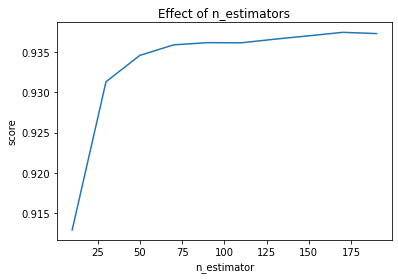

In [14]:
model = RandomForestRegressor() 

# Use the effect_estimators function to get the best model, predictions, and best score
bergamo_rf_model, bergamo_rf_pred, bergamo_rf_score = effect_estimators(train_x_bergamo, train_y_bergamo, test_x_bergamo)
print("Best Score:", bergamo_rf_score)
print()

# Call the eval_metrics function and store the results in variables
bergamo_rf_adj_R, bergamo_rf_rmse, bergamo_rf_mae, bergamo_rf_accuracy = eval_metrics(test_y_bergamo, bergamo_rf_pred, train_x_bergamo)

# Print the results
print("Adjusted R-squared:", bergamo_rf_adj_R)
print("RMSE:", bergamo_rf_rmse)
print("Mean Absolute Error:", bergamo_rf_mae)
print("Accuracy:", bergamo_rf_accuracy, "%")

In [17]:
bergamo_rf_model

RandomForestRegressor(n_estimators=190, random_state=123)

### Gradient Boosting

Best Score: 0.7464532244997337

Adjusted R-squared: 0.55
RMSE: 5.46
Mean Absolute Error: 0.2
Accuracy: 80.12 %


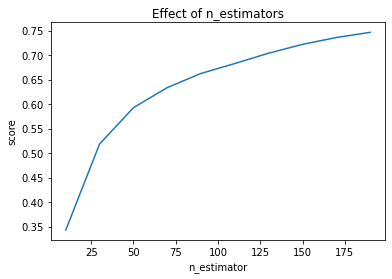

In [18]:
model = GradientBoostingRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
bergamo_gb_model, bergamo_gb_pred, bergamo_gb_score = effect_estimators(train_x_bergamo, train_y_bergamo, test_x_bergamo)
print("Best Score:", bergamo_gb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
bergamo_gb_adj_R, bergamo_gb_rmse, bergamo_gb_mae, bergamo_gb_accuracy = eval_metrics(test_y_bergamo, bergamo_gb_pred, train_x_bergamo)

# Print the results
print("Adjusted R-squared:", bergamo_gb_adj_R)
print("RMSE:", bergamo_gb_rmse)
print("Mean Absolute Error:", bergamo_gb_mae)
print("Accuracy:", bergamo_gb_accuracy, "%")

In [19]:
bergamo_gb_model

GradientBoostingRegressor(n_estimators=190, random_state=123)

### Light GBM

Best Score: 0.9644134182815545

Adjusted R-squared: 0.57
RMSE: 5.37
Mean Absolute Error: 0.19
Accuracy: 80.57 %


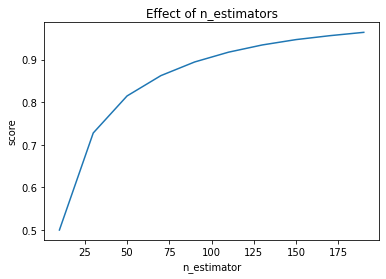

In [20]:
model = lgb.LGBMRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
bergamo_lgb_model, bergamo_lgb_pred, bergamo_lgb_score = effect_estimators(train_x_bergamo, train_y_bergamo, test_x_bergamo)
print("Best Score:", bergamo_lgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
bergamo_lgb_adj_R, bergamo_lgb_rmse, bergamo_lgb_mae, bergamo_lgb_accuracy = eval_metrics(test_y_bergamo, bergamo_lgb_pred, train_x_bergamo)

# Print the results
print("Adjusted R-squared:", bergamo_lgb_adj_R)
print("RMSE:", bergamo_lgb_rmse)
print("Mean Absolute Error:", bergamo_lgb_mae)
print("Accuracy:", bergamo_lgb_accuracy, "%")

In [21]:
bergamo_lgb_model

LGBMRegressor(n_estimators=190, random_state=123)

### XGBoost

Best Score: 0.9994935368496882

Adjusted R-squared: 0.53
RMSE: 5.59
Mean Absolute Error: 0.2
Accuracy: 80.29 %


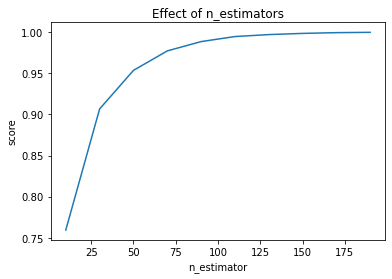

In [22]:
model = xgb.XGBRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
bergamo_xgb_model, bergamo_xgb_pred, bergamo_xgb_score = effect_estimators(train_x_bergamo, train_y_bergamo, test_x_bergamo)
print("Best Score:", bergamo_xgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
bergamo_xgb_adj_R, bergamo_xgb_rmse, bergamo_xgb_mae, bergamo_xgb_accuracy = eval_metrics(test_y_bergamo, bergamo_xgb_pred, train_x_bergamo)

# Print the results
print("Adjusted R-squared:", bergamo_xgb_adj_R)
print("RMSE:", bergamo_xgb_rmse)
print("Mean Absolute Error:", bergamo_xgb_mae)
print("Accuracy:", bergamo_xgb_accuracy, "%")

In [23]:
bergamo_xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

                    Variable  Importance
0                  host_loc2    0.381134
1  host_total_listings_count    0.075860
2                  room_type    0.063922
3                      email    0.050609
4               bathroom_num    0.036442
5             minimum_nights    0.034062
6           instant_bookable    0.029463
7          number_of_reviews    0.024384
8                   bedrooms    0.021199
9      property_type_encoded    0.020693


<AxesSubplot:title={'center':'Random Forest Feature Importance'}, xlabel='Importance', ylabel='Variable'>

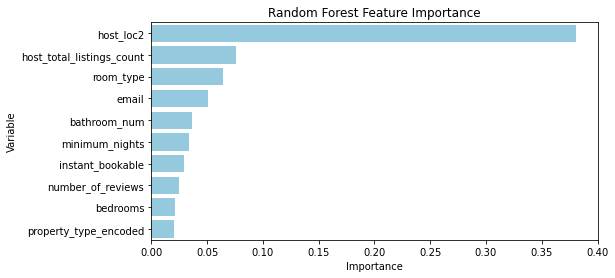

In [24]:
bergamo_xgb_10top = important_features(bergamo_xgb_model, x_bergamo)
print(bergamo_xgb_10top)

plt.figure(figsize=(8,4))
plt.title('Random Forest Feature Importance')
sns.barplot(y='Variable', x='Importance', data=bergamo_xgb_10top, color='skyblue')

### Ensemble Stacking

Best Score: 0.9996393110774995

Adjusted R-squared: 1.0
RMSE: 0.16
Mean Absolute Error: 0.01
Accuracy: 99.41 %


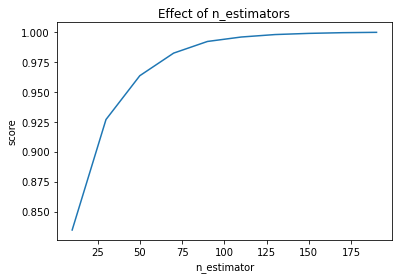

In [25]:
model = xgb.XGBRegressor()   
# Create a new feature matrix with base learners' predictions as meta-features
bergamo_meta_features = np.column_stack((bergamo_rf_pred, bergamo_gb_pred, bergamo_lgb_pred))

# Use the effect_estimators function to get the best model, predictions, and best score
bergamo_stack_model, bergamo_stack_pred, bergamo_stack_score = effect_estimators(bergamo_meta_features, test_y_bergamo, bergamo_meta_features)
print("Best Score:", bergamo_stack_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
bergamo_stack_adj_R, bergamo_stack_rmse, bergamo_stack_mae, bergamo_stack_accuracy = eval_metrics(test_y_bergamo, 
                                                                                                  bergamo_stack_pred, bergamo_meta_features)

# Print the results
print("Adjusted R-squared:", bergamo_stack_adj_R)
print("RMSE:", bergamo_stack_rmse)
print("Mean Absolute Error:", bergamo_stack_mae)
print("Accuracy:", bergamo_stack_accuracy, "%")

In [228]:
bergamo_stack_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Bayesian optimisation

In [26]:
# Meta Learner
bergamo_meta_learner = xgb.XGBRegressor(n_estimators=100, random_state=123)

# Perform Bayesian Search for the meta-learner
bergamo_bayes_opt = BayesSearchCV(bergamo_meta_learner, bayes_search, n_iter=10, cv=10, 
                         scoring="neg_mean_squared_error", verbose=4, random_state=123) 

# Fit the optimized meta-learner on the meta-features
bergamo_bayes_opt.fit(bergamo_meta_features, test_y_bergamo)

# Make predictions using the meta-learner on the test data
bergamo_bayes_pred = bergamo_bayes_opt.predict(bergamo_meta_features)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-25.115 total time=   0.7s
[CV 2/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-26.198 total time=   0.6s
[CV 3/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-49.204 total time=   0.6s
[CV 4/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-38.797 total time=   0.7s
[CV 5/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-21.988 total time=   0.6s
[CV 6/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-21.970 total time=   0.6s
[CV 7/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimator

[CV 8/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-33.804 total time=   1.5s
[CV 9/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-53.979 total time=   1.5s
[CV 10/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-48.485 total time=   1.3s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-21.094 total time=   1.0s
[CV 2/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-24.122 total time=   1.1s
[CV 3/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-49.070 total time=   1.2s
[CV 4/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183

In [27]:
# Access the best results
print("Best MSE Score:", -bergamo_bayes_opt.best_score_)
print("Best Parameters:", bergamo_bayes_opt.best_params_)

Best MSE Score: 34.799867439003776
Best Parameters: OrderedDict([('gamma', 0.7703399241440627), ('learning_rate', 0.19204784774815406), ('max_depth', 2), ('n_estimators', 764)])


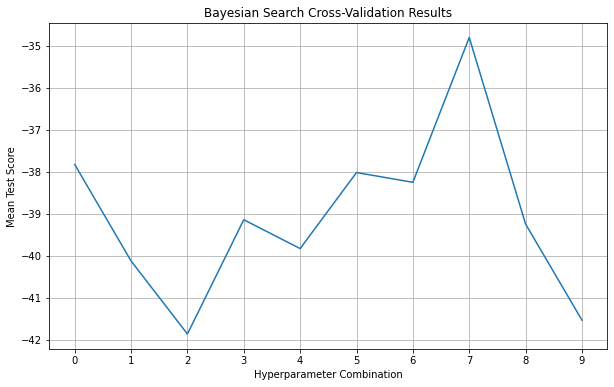

In [28]:
# Get the cv_results_ from the BayesSearchCV
bergamo_bayes_results = bergamo_bayes_opt.cv_results_

# Convert cv_results to a Pandas DataFrame
bergamo_bayes_results_df = pd.DataFrame(bergamo_bayes_results)

# Create a line plot to visualize the mean scores for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.plot(bergamo_bayes_results_df.index, bergamo_bayes_results_df['mean_test_score'])
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Bayesian Search Cross-Validation Results')
plt.xticks(bergamo_bayes_results_df.index)
plt.grid(True)
plt.show()

In [29]:
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
bergamo_bayes_adj_R, bergamo_bayes_rmse, bergamo_bayes_mae, bergamo_bayes_accuracy = eval_metrics(test_y_bergamo, 
                                                                                                  bergamo_bayes_pred, bergamo_meta_features)

# Print the results
print("Adjusted R-squared:", bergamo_bayes_adj_R)
print("RMSE:", bergamo_bayes_rmse)
print("Mean Absolute Error:", bergamo_bayes_mae)
print("Accuracy:", bergamo_bayes_accuracy, "%")

Adjusted R-squared: 0.94
RMSE: 2.09
Mean Absolute Error: 0.08
Accuracy: 91.77 %


https://aviral-agarwal.medium.com/implementation-of-genetic-algorithm-evolutionary-algorithm-in-python-using-deap-framework-c2d4bd247f70

### Genetic Algorithm

Generation 1, RMSE: 4.14, MAE: 0.16, Accuracy: 84.43
Generation 2, RMSE: 8.38, MAE: 0.32, Accuracy: 68.48
Generation 3, RMSE: 5.04, MAE: 0.17, Accuracy: 83.33
Generation 4, RMSE: 5.9, MAE: 0.19, Accuracy: 81.48
Generation 5, RMSE: 3.7, MAE: 0.14, Accuracy: 85.91
Generation 6, RMSE: 2.4, MAE: 0.09, Accuracy: 91.31
Generation 7, RMSE: 2.4, MAE: 0.09, Accuracy: 91.31
Generation 8, RMSE: 3.75, MAE: 0.14, Accuracy: 85.61
Generation 9, RMSE: 3.01, MAE: 0.11, Accuracy: 89.02
Generation 10, RMSE: 3.01, MAE: 0.11, Accuracy: 89.02
Generation 11, RMSE: 3.01, MAE: 0.11, Accuracy: 89.02
Generation 12, RMSE: 2.45, MAE: 0.09, Accuracy: 91.04
Generation 13, RMSE: 3.14, MAE: 0.12, Accuracy: 88.42
Generation 14, RMSE: 3.56, MAE: 0.13, Accuracy: 86.94
Generation 15, RMSE: 3.55, MAE: 0.12, Accuracy: 88.13
Generation 16, RMSE: 2.05, MAE: 0.07, Accuracy: 92.91
Generation 17, RMSE: 2.3, MAE: 0.09, Accuracy: 91.28
Generation 18, RMSE: 2.35, MAE: 0.09, Accuracy: 91.17
Generation 19, RMSE: 2.84, MAE: 0.11, Accu

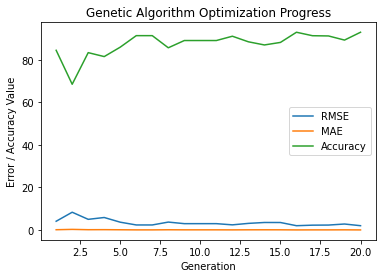

In [30]:
# optimize_GA function running
best_GAmodel_bergamo = optimize_GA(bergamo_meta_features, test_y_bergamo)

In [31]:
# Use the best model 
best_GAmodel_bergamo.fit(bergamo_meta_features, test_y_bergamo)
bergamo_GA_pred = best_GAmodel_bergamo.predict(bergamo_meta_features)
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
bergamo_GA_adj_R, bergamo_GA_rmse, bergamo_GA_mae, bergamo_GA_accuracy = eval_metrics(test_y_bergamo, 
                                                                                      bergamo_GA_pred, bergamo_meta_features)
# Print the results
print("Adjusted R-squared:", bergamo_GA_adj_R)
print("RMSE:", bergamo_GA_rmse)
print("Mean Absolute Error:", bergamo_GA_mae)
print("Accuracy:", bergamo_GA_accuracy, "%")

Adjusted R-squared: 0.94
RMSE: 2.05
Mean Absolute Error: 0.07
Accuracy: 92.91 %


In [32]:
best_GAmodel_bergamo

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.07173330604877207,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.3661267728814921, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## roma

In [33]:
# Data Import
roma_df = pd.read_csv('roma_df.csv')

nbhd_cleansed_encoder(roma_df)

# Create a new column called 'distance_from_centre'
# Official location of the city
roma_latitude = 41.902782
roma_longitude = 12.496366

# Calculate the distance between each property location and the city centre
roma_df['distance_from_centre'] = roma_df.apply(lambda row: haversine_distance(roma_latitude, roma_longitude, row['latitude'], row['longitude']), axis=1)
roma_df['distance_from_centre']

0        20.318721
1        20.283217
2         3.746352
3        24.707470
4         2.182298
           ...    
24771    27.973758
24772    22.304752
24773    24.608561
24774    22.134896
24775    28.700186
Name: distance_from_centre, Length: 24776, dtype: float64

In [34]:
roma_annual = roma_df.drop(['latitude', 'longitude'], axis=1)
roma_annual.head()

,neighborhood_overview,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,room_type,accommodates,bedrooms,beds,amenities,minimum_nights,maximum_nights,has_availability,availability_30,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,license,instant_bookable,reviews_per_month,profitability_by_numOfYears,host_loc2,email,phone,work_email,bathroom_num,bathroom_type,property_type_encoded,neighbourhood_cleansed_encoded,distance_from_centre
0,0,1,3.0,100.0,0.0,0,3.0,3,6,2.0,4.0,25,2,60,1,0,0,0,0,0,0,-1.00,0,0,-1.00,19.18,1,1,1,0,2.0,-1.0,25,9,20.318721
1,1,1,3.0,100.0,0.0,0,3.0,3,6,2.0,4.0,38,1,10,1,0,0,0,4,0,0,5.00,0,0,0.13,11.16,1,1,1,0,2.0,-1.0,25,9,20.283217
2,1,1,1.0,69.0,86.0,1,4.0,3,1,1.0,1.0,24,3,30,1,5,6,41,131,18,0,4.74,1,0,1.68,15.12,1,1,1,0,1.0,-1.0,25,8,3.746352
3,1,1,3.0,98.0,100.0,0,319.0,3,16,11.0,12.0,23,28,28,1,5,49,183,4,2,1,4.75,0,1,0.29,46.38,0,1,1,0,10.0,-1.0,20,13,24.707470
4,1,1,3.0,100.0,90.0,0,387.0,3,2,-1.0,1.0,12,1,1125,1,29,89,364,2,0,0,4.00,0,0,0.04,35.83,0,1,1,0,1.0,-1.0,25,0,2.182298


In [35]:
first_column = roma_annual.pop('profitability_by_numOfYears')
roma_annual.insert(0, 'profitability_by_numOfYears', first_column)

# roma_df
x_roma = roma_annual.iloc[:, 2: ]
y_roma = roma_annual.iloc[:, 0: 1]

# train / test split
train_x_roma, test_x_roma, train_y_roma, test_y_roma = train_test_split(x_roma, y_roma, test_size = 0.25, random_state = 123)

# Assuming y is a DataFrame, convert it to a numpy array and then ravel
train_y_roma = train_y_roma.values.ravel()
test_y_roma = test_y_roma.values.ravel()

print('Training Features Shape:', train_x_roma.shape)
print('Training Labels Shape:', train_y_roma.shape)
print('Testing Features Shape:', test_x_roma.shape)
print('Testing Labels Shape:', test_y_roma.shape)

Training Features Shape: (18582, 33)
Training Labels Shape: (18582,)
Testing Features Shape: (6194, 33)
Testing Labels Shape: (6194,)


### Random Forest

Best Score: 0.9435006353944411
Adjusted R-squared: 0.62
RMSE: 4.9
Mean Absolute Error: 0.17
Accuracy: 83.06 %


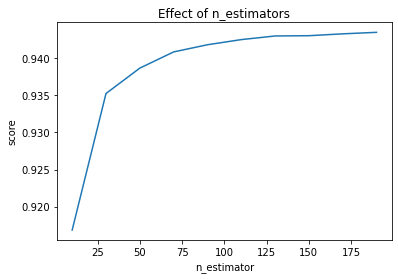

In [36]:
model = RandomForestRegressor() 

# Use the effect_estimators function to get the best model, predictions, and best score
roma_rf_model, roma_rf_pred, roma_rf_score = effect_estimators(train_x_roma, train_y_roma, test_x_roma)
print("Best Score:", roma_rf_score)

# Call the eval_metrics function and store the results in variables
roma_rf_adj_R, roma_rf_rmse, roma_rf_mae, roma_rf_accuracy = eval_metrics(test_y_roma, roma_rf_pred, train_x_roma)

# Print the results
print("Adjusted R-squared:", roma_rf_adj_R)
print("RMSE:", roma_rf_rmse)
print("Mean Absolute Error:", roma_rf_mae)
print("Accuracy:", roma_rf_accuracy, "%")

### Gradient Boosting

Best Score: 0.5809983303521711

Adjusted R-squared: 0.55
RMSE: 5.34
Mean Absolute Error: 0.19
Accuracy: 81.48 %


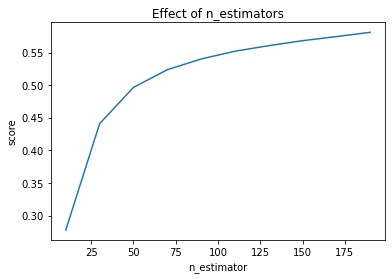

In [37]:
model = GradientBoostingRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
roma_gb_model, roma_gb_pred, roma_gb_score = effect_estimators(train_x_roma, train_y_roma, test_x_roma)
print("Best Score:", roma_gb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
roma_gb_adj_R, roma_gb_rmse, roma_gb_mae, roma_gb_accuracy = eval_metrics(test_y_roma, roma_gb_pred, train_x_roma)

# Print the results
print("Adjusted R-squared:", roma_gb_adj_R)
print("RMSE:", roma_gb_rmse)
print("Mean Absolute Error:", roma_gb_mae)
print("Accuracy:", roma_gb_accuracy, "%")

### Light GBM

Best Score: 0.7440203395584839

Adjusted R-squared: 0.62
RMSE: 4.95
Mean Absolute Error: 0.17
Accuracy: 82.9 %


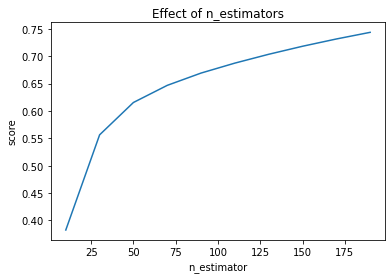

In [38]:
model = lgb.LGBMRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
roma_lgb_model, roma_lgb_pred, roma_lgb_score = effect_estimators(train_x_roma, train_y_roma, test_x_roma)
print("Best Score:", roma_lgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
roma_lgb_adj_R, roma_lgb_rmse, roma_lgb_mae, roma_lgb_accuracy = eval_metrics(test_y_roma, roma_lgb_pred, train_x_roma)

# Print the results
print("Adjusted R-squared:", roma_lgb_adj_R)
print("RMSE:", roma_lgb_rmse)
print("Mean Absolute Error:", roma_lgb_mae)
print("Accuracy:", roma_lgb_accuracy, "%")

### XGBoost

Best Score: 0.887418755181014

Adjusted R-squared: 0.6
RMSE: 5.03
Mean Absolute Error: 0.17
Accuracy: 82.94 %


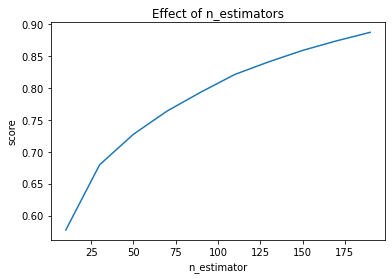

In [39]:
model = xgb.XGBRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
roma_xgb_model, roma_xgb_pred, roma_xgb_score = effect_estimators(train_x_roma, train_y_roma, test_x_roma)
print("Best Score:", roma_xgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
roma_xgb_adj_R, roma_xgb_rmse, roma_xgb_mae, roma_xgb_accuracy = eval_metrics(test_y_roma, roma_xgb_pred, train_x_roma)

# Print the results
print("Adjusted R-squared:", roma_xgb_adj_R)
print("RMSE:", roma_xgb_rmse)
print("Mean Absolute Error:", roma_xgb_mae)
print("Accuracy:", roma_xgb_accuracy, "%")

                         Variable  Importance
0                       host_loc2    0.217217
1  neighbourhood_cleansed_encoded    0.054666
2                        bedrooms    0.049861
3                    bathroom_num    0.048744
4                instant_bookable    0.047594
5                    accommodates    0.045671
6       host_total_listings_count    0.043706
7               number_of_reviews    0.041842
8                       room_type    0.039536
9           property_type_encoded    0.037917


<AxesSubplot:title={'center':'XGBoost Importance of Roma'}, xlabel='Importance', ylabel='Variable'>

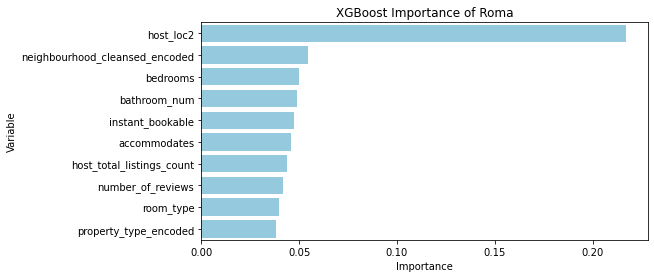

In [40]:
roma_xgb_10top = important_features(roma_xgb_model, x_roma)
print(roma_xgb_10top)

plt.figure(figsize=(8,4))
plt.title('XGBoost Importance of Roma')
sns.barplot(y='Variable', x='Importance', data=roma_xgb_10top, color='skyblue')

### Ensemble Stacking

Best Score: 0.9042101279264693

Adjusted R-squared: 0.9
RMSE: 2.48
Mean Absolute Error: 0.08
Accuracy: 91.58 %


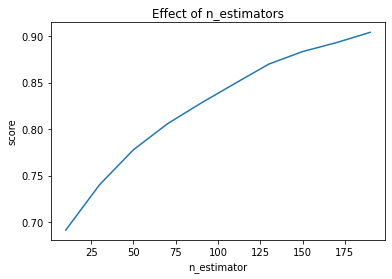

In [41]:
model = xgb.XGBRegressor()   
# Create a new feature matrix with base learners' predictions as meta-features
roma_meta_features = np.column_stack((roma_rf_pred, roma_gb_pred, roma_lgb_pred))

# Use the effect_estimators function to get the best model, predictions, and best score
roma_stack_model, roma_stack_pred, roma_stack_score = effect_estimators(roma_meta_features, test_y_roma, roma_meta_features)

print("Best Score:", roma_stack_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
roma_stack_adj_R, roma_stack_rmse, roma_stack_mae, roma_stack_accuracy = eval_metrics(test_y_roma, roma_stack_pred, roma_meta_features)

# Print the results
print("Adjusted R-squared:", roma_stack_adj_R)
print("RMSE:", roma_stack_rmse)
print("Mean Absolute Error:", roma_stack_mae)
print("Accuracy:", roma_stack_accuracy, "%")

### Bayesian optimisation

In [42]:
# Meta Learner
roma_meta_learner = xgb.XGBRegressor(n_estimators=100, random_state=123)

# Perform Bayesian Search for the meta-learner
roma_bayes_opt = BayesSearchCV(roma_meta_learner, bayes_search, n_iter=10, cv=10, 
                         scoring="neg_mean_squared_error", verbose=4, random_state=123) 

# Fit the optimized meta-learner on the meta-features
roma_bayes_opt.fit(roma_meta_features, test_y_roma)

# Make predictions using the meta-learner on the test data
roma_bayes_pred = roma_bayes_opt.predict(roma_meta_features)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-30.087 total time=   2.0s
[CV 2/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-27.385 total time=   2.0s
[CV 3/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-24.566 total time=   2.0s
[CV 4/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-21.284 total time=   2.3s
[CV 5/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-28.019 total time=   1.9s
[CV 6/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-25.194 total time=   1.9s
[CV 7/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimator

[CV 8/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-31.486 total time=   6.8s
[CV 9/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-36.013 total time=   7.0s
[CV 10/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-33.323 total time=   6.8s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-34.951 total time=   4.8s
[CV 2/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-33.861 total time=   4.6s
[CV 3/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-31.064 total time=   4.8s
[CV 4/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183

In [43]:
# Access the best results
print("Best MSE Score:", -roma_bayes_opt.best_score_)
print("Best Parameters:", roma_bayes_opt.best_params_)

Best MSE Score: 25.559452086370488
Best Parameters: OrderedDict([('gamma', 0.7703399241440627), ('learning_rate', 0.19204784774815406), ('max_depth', 2), ('n_estimators', 764)])


Adjusted R-squared: 0.75
RMSE: 3.97
Mean Absolute Error: 0.14
Accuracy: 86.18 %


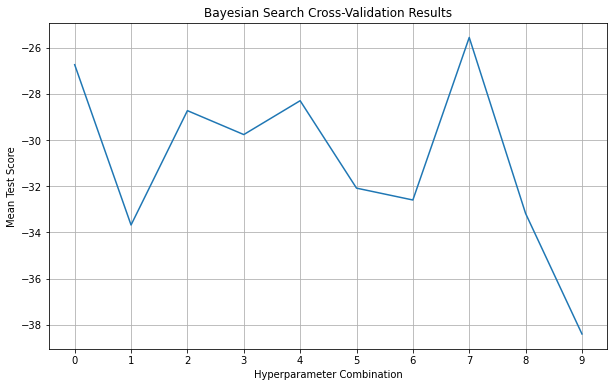

In [44]:
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
roma_bayes_adj_R, roma_bayes_rmse, roma_bayes_mae, roma_bayes_accuracy = eval_metrics(test_y_roma, roma_bayes_pred, roma_meta_features)

# Print the results
print("Adjusted R-squared:", roma_bayes_adj_R)
print("RMSE:", roma_bayes_rmse)
print("Mean Absolute Error:", roma_bayes_mae)
print("Accuracy:", roma_bayes_accuracy, "%")

# Get the cv_results_ from the BayesSearchCV
roma_bayes_results = roma_bayes_opt.cv_results_

# Convert cv_results to a Pandas DataFrame
roma_bayes_results_df = pd.DataFrame(roma_bayes_results)

# Create a line plot to visualize the mean scores for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.plot(roma_bayes_results_df.index, roma_bayes_results_df['mean_test_score'])
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Bayesian Search Cross-Validation Results')
plt.xticks(roma_bayes_results_df.index)
plt.grid(True)
plt.show()

### Genetic Algorithm

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'idx' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Generation 1, RMSE: 5.0, MAE: 0.17, Accuracy: 82.85
Generation 2, RMSE: 8.01, MAE: 0.3, Accuracy: 69.95
Generation 3, RMSE: 8.01, MAE: 0.3, Accuracy: 69.94
Generation 4, RMSE: 4.22, MAE: 0.15, Accuracy: 85.44
Generation 5, RMSE: 4.06, MAE: 0.14, Accuracy: 86.32
Generation 6, RMSE: 4.06, MAE: 0.14, Accuracy: 86.32
Generation 7, RMSE: 4.06, MAE: 0.14, Accuracy: 86.32
Generation 8, RMSE: 3.59, MAE: 0.13, Accuracy: 87.5
Generation 9, RMSE: 3.59, MAE: 0.13, Accuracy: 87.5
Generation 10, RMSE: 3.59, MAE: 0.13, Accuracy: 87.5
Generation 11, RMSE: 3.59, MAE: 0.13, Accuracy: 87.5
Generation 12, RMSE: 3.59, MAE: 0.13, Accuracy: 87.5
Generation 13, RMSE: 3.79, MAE: 0.13, Accuracy: 86.92
Generation 14, RMSE: 3.79, MAE: 0.13, Accuracy: 86.92
Generation 15, RMSE: 3.79, MAE: 0.13, Accuracy: 86.92
Generation 16, RMSE: 3.67, MAE: 0.12, Accuracy: 87.54
Generation 17, RMSE: 3.67, MAE: 0.12, Accuracy: 87.54
Generation 18, RMSE: 3.67, MAE: 0.12, Accuracy: 87.54
Generation 19, RMSE: 3.67, MAE: 0.12, Accurac

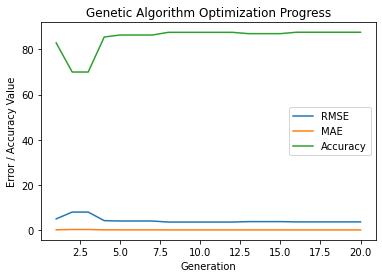

In [45]:
# optimize_GA function running
best_GAmodel_roma = optimize_GA(roma_meta_features, test_y_roma)

In [46]:
# Use the best model 
best_GAmodel_roma.fit(roma_meta_features, test_y_roma)
roma_GA_pred = best_GAmodel_roma.predict(roma_meta_features)
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
roma_GA_adj_R, roma_GA_rmse, roma_GA_mae, roma_GA_accuracy = eval_metrics(test_y_roma, roma_GA_pred, roma_meta_features)
# Print the results
print("Adjusted R-squared:", roma_GA_adj_R)
print("RMSE:", roma_GA_rmse)
print("Mean Absolute Error:", roma_GA_mae)
print("Accuracy:", roma_GA_accuracy, "%")

Adjusted R-squared: 0.79
RMSE: 3.67
Mean Absolute Error: 0.12
Accuracy: 87.54 %


## milano

In [48]:
# Data Import
milano_df = pd.read_csv('milano_df.csv')

nbhd_cleansed_encoder(milano_df)

# Create a new column called 'distance_from_centre'
# Official location of the city
milano_latitude = 45.464664
milano_longitude = 9.188540

# Calculate the distance between each property location and the city centre
milano_df['distance_from_centre'] = milano_df.apply(lambda row: haversine_distance(milano_latitude, milano_longitude, row['latitude'], row['longitude']), axis=1)
milano_df['distance_from_centre']

0         3.995389
1         6.521400
2         2.933089
3         3.464543
4         3.595800
           ...    
19243     7.513932
19244     6.604294
19245    10.765208
19246     8.597237
19247     8.359855
Name: distance_from_centre, Length: 19248, dtype: float64

In [49]:
milano_annual = milano_df.drop(['latitude', 'longitude'], axis=1)
milano_annual.head()

,neighborhood_overview,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,room_type,accommodates,bedrooms,beds,amenities,minimum_nights,maximum_nights,has_availability,availability_30,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,license,instant_bookable,reviews_per_month,profitability_by_numOfYears,host_loc2,email,phone,work_email,bathroom_num,bathroom_type,property_type_encoded,neighbourhood_cleansed_encoded,distance_from_centre
0,0,1,3.0,100.0,100.0,1,3.0,3,2,1.0,1.0,27,1,30,1,3,52,166,13,8,1,4.85,1,1,0.76,15.56,1,1,1,0,1.0,-1.0,25,58,3.995389
1,0,1,2.0,64.0,99.0,0,195.0,3,6,2.0,3.0,16,1,1125,1,4,28,181,22,11,0,4.33,0,1,0.33,35.21,1,1,1,0,1.0,-1.0,25,24,6.521400
2,0,0,3.0,100.0,91.0,0,7.0,1,1,1.0,1.0,6,10,365,1,0,0,266,0,0,0,-1.00,0,0,-1.00,16.68,1,1,1,1,1.0,0.0,72,72,2.933089
3,1,1,3.0,100.0,100.0,1,3.0,3,3,1.0,1.0,40,3,30,1,22,82,82,44,24,4,4.98,0,1,0.90,23.22,1,1,1,0,1.0,-1.0,25,38,3.464543
4,1,1,3.0,100.0,100.0,0,18.0,2,2,1.0,1.0,33,1,90,1,0,31,109,5,0,0,4.80,0,1,0.14,26.31,1,1,1,0,1.0,1.0,86,37,3.595800


In [50]:
# Pop and Insert for devision of x and y
first_column = milano_annual.pop('profitability_by_numOfYears')
milano_annual.insert(0, 'profitability_by_numOfYears', first_column)
x_milano = milano_annual.iloc[:, 2: ]
y_milano = milano_annual.iloc[:, 0: 1]

# train / test split
train_x_milano, test_x_milano, train_y_milano, test_y_milano = train_test_split(x_milano, y_milano, test_size = 0.25, random_state = 123)

# Assuming y is a DataFrame, convert it to a numpy array and then ravel
train_y_milano = train_y_milano.values.ravel()
test_y_milano = test_y_milano.values.ravel()

print('Training Features Shape:', train_x_milano.shape)
print('Training Labels Shape:', train_y_milano.shape)
print('Testing Features Shape:', test_x_milano.shape)
print('Testing Labels Shape:', test_y_milano.shape)

Training Features Shape: (14436, 33)
Training Labels Shape: (14436,)
Testing Features Shape: (4812, 33)
Testing Labels Shape: (4812,)


### Random Forest

Best Score: 0.9447988358966399
Adjusted R-squared: 0.59
RMSE: 5.32
Mean Absolute Error: 0.18
Accuracy: 81.74 %


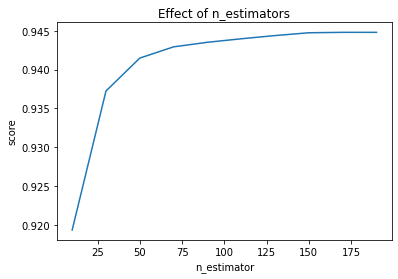

In [51]:
model = RandomForestRegressor() 

# Use the effect_estimators function to get the best model, predictions, and best score
milano_rf_model, milano_rf_pred, milano_rf_score = effect_estimators(train_x_milano, train_y_milano, test_x_milano)
print("Best Score:", milano_rf_score)

# Call the eval_metrics function and store the results in variables
milano_rf_adj_R, milano_rf_rmse, milano_rf_mae, milano_rf_accuracy = eval_metrics(test_y_milano, milano_rf_pred, train_x_milano)

# Print the results
print("Adjusted R-squared:", milano_rf_adj_R)
print("RMSE:", milano_rf_rmse)
print("Mean Absolute Error:", milano_rf_mae)
print("Accuracy:", milano_rf_accuracy, "%")

### Gradient Boosting

Best Score: 0.61861340284081

Adjusted R-squared: 0.56
RMSE: 5.52
Mean Absolute Error: 0.19
Accuracy: 80.83 %


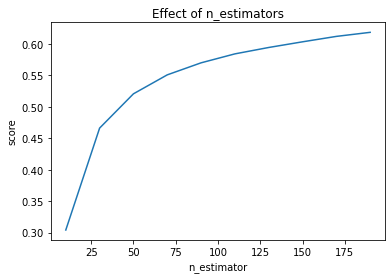

In [52]:
model = GradientBoostingRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
milano_gb_model, milano_gb_pred, milano_gb_score = effect_estimators(train_x_milano, train_y_milano, test_x_milano)
print("Best Score:", milano_gb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
milano_gb_adj_R, milano_gb_rmse, milano_gb_mae, milano_gb_accuracy = eval_metrics(test_y_milano, milano_gb_pred, train_x_milano)

# Print the results
print("Adjusted R-squared:", milano_gb_adj_R)
print("RMSE:", milano_gb_rmse)
print("Mean Absolute Error:", milano_gb_mae)
print("Accuracy:", milano_gb_accuracy, "%")

### Light GBM

Best Score: 0.7763945069018882

Adjusted R-squared: 0.62
RMSE: 5.17
Mean Absolute Error: 0.18
Accuracy: 82.17 %


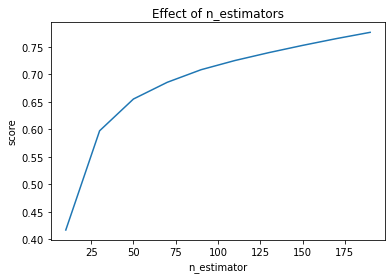

In [53]:
model = lgb.LGBMRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
milano_lgb_model, milano_lgb_pred, milano_lgb_score = effect_estimators(train_x_milano, train_y_milano, test_x_milano)
print("Best Score:", milano_lgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
milano_lgb_adj_R, milano_lgb_rmse, milano_lgb_mae, milano_lgb_accuracy = eval_metrics(test_y_milano, milano_lgb_pred, train_x_milano)

# Print the results
print("Adjusted R-squared:", milano_lgb_adj_R)
print("RMSE:", milano_lgb_rmse)
print("Mean Absolute Error:", milano_lgb_mae)
print("Accuracy:", milano_lgb_accuracy, "%")

### XGBoost

Best Score: 0.9137540734030541

Adjusted R-squared: 0.6
RMSE: 5.29
Mean Absolute Error: 0.18
Accuracy: 81.8 %


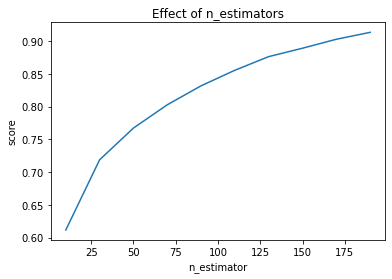

In [54]:
model = xgb.XGBRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
milano_xgb_model, milano_xgb_pred, milano_xgb_score = effect_estimators(train_x_milano, train_y_milano, test_x_milano)
print("Best Score:", milano_xgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
milano_xgb_adj_R, milano_xgb_rmse, milano_xgb_mae, milano_xgb_accuracy = eval_metrics(test_y_milano, milano_xgb_pred, train_x_milano)

# Print the results
print("Adjusted R-squared:", milano_xgb_adj_R)
print("RMSE:", milano_xgb_rmse)
print("Mean Absolute Error:", milano_xgb_mae)
print("Accuracy:", milano_xgb_accuracy, "%")

                    Variable  Importance
0                  host_loc2    0.186958
1  host_total_listings_count    0.094477
2            availability_30    0.071811
3      property_type_encoded    0.066144
4               bathroom_num    0.061520
5           instant_bookable    0.051659
6                  room_type    0.050772
7                   bedrooms    0.032723
8          number_of_reviews    0.032429
9             minimum_nights    0.029822


<AxesSubplot:title={'center':'XGBoost Importance of Milano'}, xlabel='Importance', ylabel='Variable'>

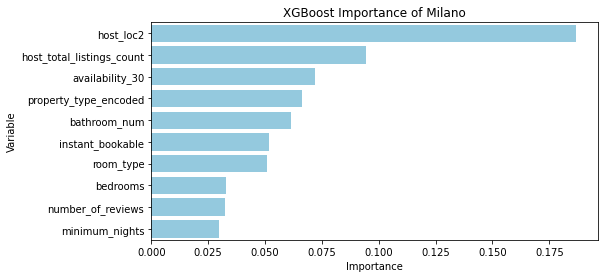

In [55]:
milano_xgb_10top = important_features(milano_xgb_model, x_milano)
print(milano_xgb_10top)

plt.figure(figsize=(8,4))
plt.title('XGBoost Importance of Milano')
sns.barplot(y='Variable', x='Importance', data=milano_xgb_10top, color='skyblue')

### Ensemble Stacking

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Best Score: 0.9317441595355849

Adjusted R-squared: 0.93
RMSE: 2.19
Mean Absolute Error: 0.08
Accuracy: 92.25 %


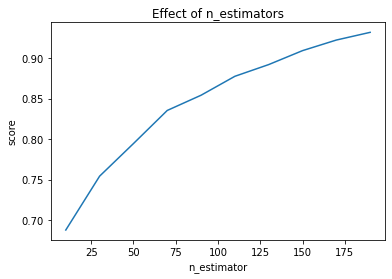

In [56]:
model = xgb.XGBRegressor()   
# Create a new feature matrix with base learners' predictions as meta-features
milano_meta_features = np.column_stack((milano_rf_pred, milano_gb_pred, milano_lgb_pred))

# Use the effect_estimators function to get the best model, predictions, and best score
milano_stack_model, milano_stack_pred, milano_stack_score = effect_estimators(milano_meta_features, test_y_milano, milano_meta_features)

print(milano_stack_model)
print()
print("Best Score:", milano_stack_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
milano_stack_adj_R, milano_stack_rmse, milano_stack_mae, milano_stack_accuracy = eval_metrics(test_y_milano, milano_stack_pred, milano_meta_features)

# Print the results
print("Adjusted R-squared:", milano_stack_adj_R)
print("RMSE:", milano_stack_rmse)
print("Mean Absolute Error:", milano_stack_mae)
print("Accuracy:", milano_stack_accuracy, "%")

### Bayesian optimisation

In [57]:
# Meta Learner
milano_meta_learner = xgb.XGBRegressor(n_estimators=100, random_state=123)

# Perform Bayesian Search for the meta-learner
milano_bayes_opt = BayesSearchCV(milano_meta_learner, bayes_search, n_iter=10, cv=10, 
                         scoring="neg_mean_squared_error", verbose=4, random_state=123) 

# Fit the optimized meta-learner on the meta-features
milano_bayes_opt.fit(milano_meta_features, test_y_milano)

# Make predictions using the meta-learner on the test data
milano_bayes_pred = milano_bayes_opt.predict(milano_meta_features)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-31.763 total time=   1.6s
[CV 2/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-31.405 total time=   1.6s
[CV 3/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-28.837 total time=   1.6s
[CV 4/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-34.872 total time=   1.6s
[CV 5/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-27.685 total time=   1.6s
[CV 6/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-32.740 total time=   1.6s
[CV 7/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimator

[CV 8/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-41.986 total time=   5.6s
[CV 9/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-38.876 total time=   5.5s
[CV 10/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-37.585 total time=   5.5s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-40.087 total time=   3.7s
[CV 2/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-38.689 total time=   3.8s
[CV 3/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-40.355 total time=   3.7s
[CV 4/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183

In [58]:
# Access the best results
print("Best MSE Score:", -milano_bayes_opt.best_score_)
print("Best Parameters:", milano_bayes_opt.best_params_)

Best MSE Score: 30.6735171235238
Best Parameters: OrderedDict([('gamma', 0.7703399241440627), ('learning_rate', 0.19204784774815406), ('max_depth', 2), ('n_estimators', 764)])


Adjusted R-squared: 0.77
RMSE: 3.98
Mean Absolute Error: 0.14
Accuracy: 85.74 %


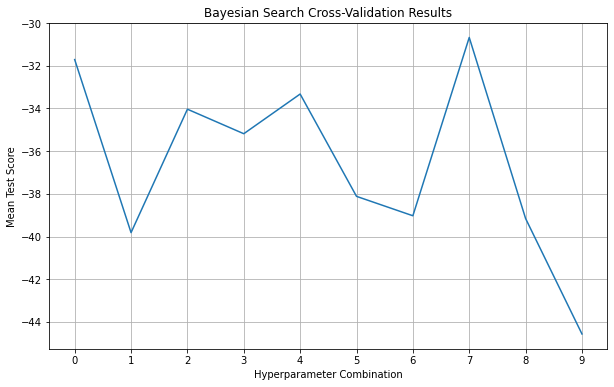

In [59]:
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
milano_bayes_adj_R, milano_bayes_rmse, milano_bayes_mae, milano_bayes_accuracy = eval_metrics(test_y_milano, milano_bayes_pred, milano_meta_features)

# Print the results
print("Adjusted R-squared:", milano_bayes_adj_R)
print("RMSE:", milano_bayes_rmse)
print("Mean Absolute Error:", milano_bayes_mae)
print("Accuracy:", milano_bayes_accuracy, "%")

# Get the cv_results_ from the BayesSearchCV
milano_bayes_results = milano_bayes_opt.cv_results_

# Convert cv_results to a Pandas DataFrame
milano_bayes_results_df = pd.DataFrame(milano_bayes_results)

# Create a line plot to visualize the mean scores for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.plot(milano_bayes_results_df.index, milano_bayes_results_df['mean_test_score'])
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Bayesian Search Cross-Validation Results')
plt.xticks(milano_bayes_results_df.index)
plt.grid(True)
plt.show()

### Genetic Algorithm

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'idx' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Generation 1, RMSE: 4.93, MAE: 0.16, Accuracy: 84.22
Generation 2, RMSE: 4.61, MAE: 0.16, Accuracy: 84.14
Generation 3, RMSE: 4.61, MAE: 0.16, Accuracy: 84.14
Generation 4, RMSE: 4.42, MAE: 0.15, Accuracy: 84.67
Generation 5, RMSE: 4.42, MAE: 0.15, Accuracy: 84.67
Generation 6, RMSE: 4.61, MAE: 0.15, Accuracy: 84.61
Generation 7, RMSE: 4.42, MAE: 0.15, Accuracy: 84.67
Generation 8, RMSE: 4.36, MAE: 0.15, Accuracy: 84.86
Generation 9, RMSE: 4.42, MAE: 0.15, Accuracy: 84.67
Generation 10, RMSE: 4.42, MAE: 0.15, Accuracy: 84.67
Generation 11, RMSE: 4.39, MAE: 0.15, Accuracy: 84.64
Generation 12, RMSE: 3.47, MAE: 0.12, Accuracy: 88.23
Generation 13, RMSE: 4.36, MAE: 0.15, Accuracy: 84.86
Generation 14, RMSE: 4.36, MAE: 0.15, Accuracy: 84.86
Generation 15, RMSE: 4.36, MAE: 0.15, Accuracy: 84.86
Generation 16, RMSE: 4.36, MAE: 0.15, Accuracy: 84.86
Generation 17, RMSE: 3.41, MAE: 0.12, Accuracy: 87.6
Generation 18, RMSE: 3.41, MAE: 0.12, Accuracy: 87.6
Generation 19, RMSE: 3.96, MAE: 0.14, A

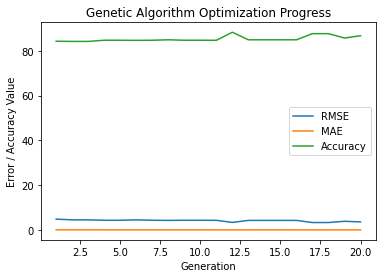

In [60]:
# optimize_GA function running
best_GAmodel_milano = optimize_GA(milano_meta_features, test_y_milano)

In [61]:
# Use the best model 
best_GAmodel_milano.fit(milano_meta_features, test_y_milano)
milano_GA_pred = best_GAmodel_milano.predict(milano_meta_features)
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
milano_GA_adj_R, milano_GA_rmse, milano_GA_mae, milano_GA_accuracy = eval_metrics(test_y_milano, milano_GA_pred, milano_meta_features)
# Print the results
print("Adjusted R-squared:", milano_GA_adj_R)
print("RMSE:", milano_GA_rmse)
print("Mean Absolute Error:", milano_GA_mae)
print("Accuracy:", milano_GA_accuracy, "%")

Adjusted R-squared: 0.83
RMSE: 3.47
Mean Absolute Error: 0.12
Accuracy: 88.23 %


## sicilia

In [63]:
# Data Import
sicilia_df = pd.read_csv('sicilia_df.csv')

nbhd_cleansed_encoder(sicilia_df)

# Create a new column called 'distance_from_centre'
# Official location of the city
sicilia_latitude = 37.500000
sicilia_longitude = 15.090278

# Calculate the distance between each property location and the city centre
sicilia_df['distance_from_centre'] = sicilia_df.apply(lambda row: haversine_distance(sicilia_latitude, sicilia_longitude, row['latitude'], row['longitude']), axis=1)
sicilia_df['distance_from_centre']

0         63.943476
1         65.964507
2         66.004294
3        107.685527
4         13.509223
            ...    
56082    111.619615
56083     25.537182
56084     32.521807
56085    108.287595
56086     78.406002
Name: distance_from_centre, Length: 56087, dtype: float64

In [64]:
sicilia_annual = sicilia_df.drop(['latitude', 'longitude'], axis=1)
sicilia_annual.head()

,neighborhood_overview,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,room_type,accommodates,bedrooms,beds,amenities,minimum_nights,maximum_nights,has_availability,availability_30,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,license,instant_bookable,reviews_per_month,profitability_by_numOfYears,host_loc2,email,phone,work_email,bathroom_num,bathroom_type,property_type_encoded,neighbourhood_cleansed_encoded,distance_from_centre
0,0,1,1.0,72.0,99.0,0,194.0,3,6,2.0,3.0,17,1,1125,1,9,69,231,26,3,0,4.12,0,1,0.51,33.29,1,1,1,0,1.0,-1.0,25,25,63.943476
1,0,1,1.0,72.0,99.0,0,194.0,3,6,1.0,3.0,17,1,1125,1,21,81,242,0,0,0,-1.00,0,1,-1.00,33.29,1,1,1,0,1.0,-1.0,25,25,65.964507
2,0,1,1.0,72.0,99.0,0,194.0,3,6,2.0,4.0,18,1,1125,1,16,71,232,8,6,0,5.00,0,1,0.54,33.29,1,1,1,0,1.0,-1.0,25,25,66.004294
3,1,0,3.0,82.0,27.0,0,2.0,3,3,1.0,2.0,25,4,1125,1,30,90,365,30,1,0,4.57,0,0,0.33,15.97,1,1,1,0,1.0,-1.0,14,93,107.685527
4,0,1,-1.0,-1.0,-1.0,0,220.0,3,8,4.0,4.0,6,1,1125,1,0,0,0,0,0,0,-1.00,0,1,-1.00,45.61,0,1,1,0,2.0,-1.0,20,363,13.509223


In [65]:
# Pop and Insert for devision of x and y
first_column = sicilia_annual.pop('profitability_by_numOfYears')
sicilia_annual.insert(0, 'profitability_by_numOfYears', first_column)
x_sicilia = sicilia_annual.iloc[:, 2: ]
y_sicilia = sicilia_annual.iloc[:, 0: 1]

# train / test split
train_x_sicilia, test_x_sicilia, train_y_sicilia, test_y_sicilia = train_test_split(x_sicilia, y_sicilia, test_size = 0.25, random_state = 123)

# Assuming y is a DataFrame, convert it to a numpy array and then ravel
train_y_sicilia = train_y_sicilia.values.ravel()
test_y_sicilia = test_y_sicilia.values.ravel()

print('Training Features Shape:', train_x_sicilia.shape)
print('Training Labels Shape:', train_y_sicilia.shape)
print('Testing Features Shape:', test_x_sicilia.shape)
print('Testing Labels Shape:', test_y_sicilia.shape)

Training Features Shape: (42065, 33)
Training Labels Shape: (42065,)
Testing Features Shape: (14022, 33)
Testing Labels Shape: (14022,)


### Random Forest

Best Score: 0.9497066931490571
Adjusted R-squared: 0.63
RMSE: 5.54
Mean Absolute Error: 0.21
Accuracy: 79.23 %


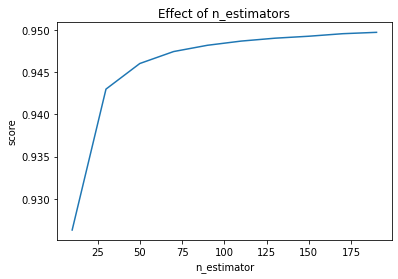

In [66]:
model = RandomForestRegressor() 

# Use the effect_estimators function to get the best model, predictions, and best score
sicilia_rf_model, sicilia_rf_pred, sicilia_rf_score = effect_estimators(train_x_sicilia, train_y_sicilia, test_x_sicilia)
print("Best Score:", sicilia_rf_score)

# Call the eval_metrics function and store the results in variables
sicilia_rf_adj_R, sicilia_rf_rmse, sicilia_rf_mae, sicilia_rf_accuracy = eval_metrics(test_y_sicilia, sicilia_rf_pred, train_x_sicilia)

# Print the results
print("Adjusted R-squared:", sicilia_rf_adj_R)
print("RMSE:", sicilia_rf_rmse)
print("Mean Absolute Error:", sicilia_rf_mae)
print("Accuracy:", sicilia_rf_accuracy, "%")

### Gradient Boosting

Best Score: 0.5889720225420516

Adjusted R-squared: 0.56
RMSE: 5.99
Mean Absolute Error: 0.23
Accuracy: 77.29 %


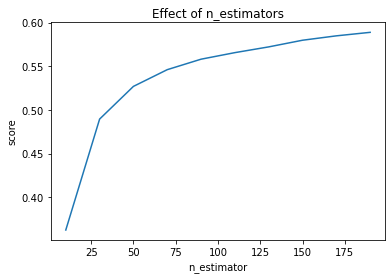

In [67]:
model = GradientBoostingRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
sicilia_gb_model, sicilia_gb_pred, sicilia_gb_score = effect_estimators(train_x_sicilia, train_y_sicilia, test_x_sicilia)
print("Best Score:", sicilia_gb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
sicilia_gb_adj_R, sicilia_gb_rmse, sicilia_gb_mae, sicilia_gb_accuracy = eval_metrics(test_y_sicilia, sicilia_gb_pred, train_x_sicilia)

# Print the results
print("Adjusted R-squared:", sicilia_gb_adj_R)
print("RMSE:", sicilia_gb_rmse)
print("Mean Absolute Error:", sicilia_gb_mae)
print("Accuracy:", sicilia_gb_accuracy, "%")

### Light GBM

Best Score: 0.7009565011051802

Adjusted R-squared: 0.63
RMSE: 5.54
Mean Absolute Error: 0.21
Accuracy: 79.43 %


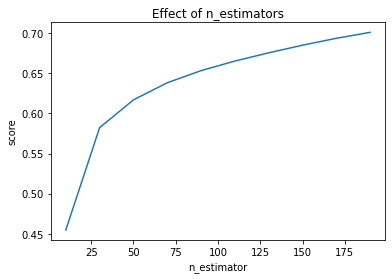

In [68]:
model = lgb.LGBMRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
sicilia_lgb_model, sicilia_lgb_pred, sicilia_lgb_score = effect_estimators(train_x_sicilia, train_y_sicilia, test_x_sicilia)
print("Best Score:", sicilia_lgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
sicilia_lgb_adj_R, sicilia_lgb_rmse, sicilia_lgb_mae, sicilia_lgb_accuracy = eval_metrics(test_y_sicilia, sicilia_lgb_pred, train_x_sicilia)

# Print the results
print("Adjusted R-squared:", sicilia_lgb_adj_R)
print("RMSE:", sicilia_lgb_rmse)
print("Mean Absolute Error:", sicilia_lgb_mae)
print("Accuracy:", sicilia_lgb_accuracy, "%")

### XGBoost

Best Score: 0.8056542405390605

Adjusted R-squared: 0.63
RMSE: 5.49
Mean Absolute Error: 0.2
Accuracy: 79.75 %


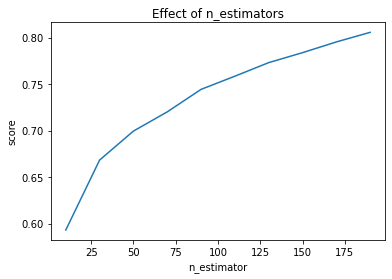

In [69]:
model = xgb.XGBRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
sicilia_xgb_model, sicilia_xgb_pred, sicilia_xgb_score = effect_estimators(train_x_sicilia, train_y_sicilia, test_x_sicilia)
print("Best Score:", sicilia_xgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
sicilia_xgb_adj_R, sicilia_xgb_rmse, sicilia_xgb_mae, sicilia_xgb_accuracy = eval_metrics(test_y_sicilia, sicilia_xgb_pred, train_x_sicilia)

# Print the results
print("Adjusted R-squared:", sicilia_xgb_adj_R)
print("RMSE:", sicilia_xgb_rmse)
print("Mean Absolute Error:", sicilia_xgb_mae)
print("Accuracy:", sicilia_xgb_accuracy, "%")

                    Variable  Importance
0                  host_loc2    0.336593
1  host_total_listings_count    0.082526
2               bathroom_num    0.061922
3          number_of_reviews    0.059278
4                   bedrooms    0.043714
5                 host_about    0.040105
6             maximum_nights    0.035273
7                  room_type    0.032950
8           instant_bookable    0.026402
9      property_type_encoded    0.024987


<AxesSubplot:title={'center':'XGBoost Importance of Sicilia'}, xlabel='Importance', ylabel='Variable'>

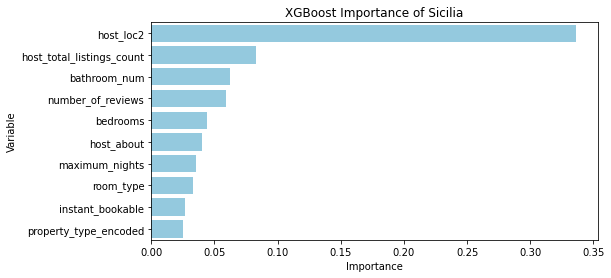

In [70]:
sicilia_xgb_10top = important_features(sicilia_xgb_model, x_sicilia)
print(sicilia_xgb_10top)

plt.figure(figsize=(8,4))
plt.title('XGBoost Importance of Sicilia')
sns.barplot(y='Variable', x='Importance', data=sicilia_xgb_10top, color='skyblue')

### Ensemble Stacking

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Best Score: 0.838496628068537

Adjusted R-squared: 0.84
RMSE: 3.65
Mean Absolute Error: 0.14
Accuracy: 86.22 %


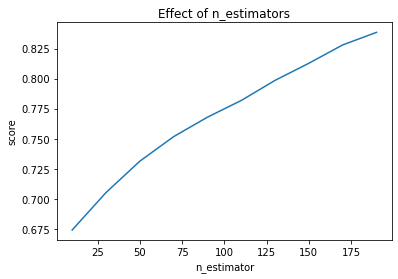

In [71]:
model = xgb.XGBRegressor()   
# Create a new feature matrix with base learners' predictions as meta-features
sicilia_meta_features = np.column_stack((sicilia_rf_pred, sicilia_gb_pred, sicilia_lgb_pred))

# Use the effect_estimators function to get the best model, predictions, and best score
sicilia_stack_model, sicilia_stack_pred, sicilia_stack_score = effect_estimators(sicilia_meta_features, test_y_sicilia, sicilia_meta_features)

print(sicilia_stack_model)
print()
print("Best Score:", sicilia_stack_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
sicilia_stack_adj_R, sicilia_stack_rmse, sicilia_stack_mae, sicilia_stack_accuracy = eval_metrics(test_y_sicilia, sicilia_stack_pred, sicilia_meta_features)

# Print the results
print("Adjusted R-squared:", sicilia_stack_adj_R)
print("RMSE:", sicilia_stack_rmse)
print("Mean Absolute Error:", sicilia_stack_mae)
print("Accuracy:", sicilia_stack_accuracy, "%")

### Bayesian optimisation

In [72]:
# Meta Learner
sicilia_meta_learner = xgb.XGBRegressor(n_estimators=100, random_state=123)

# Perform Bayesian Search for the meta-learner
sicilia_bayes_opt = BayesSearchCV(sicilia_meta_learner, bayes_search, n_iter=10, cv=10, 
                         scoring="neg_mean_squared_error", verbose=4, random_state=123) 

# Fit the optimized meta-learner on the meta-features
sicilia_bayes_opt.fit(sicilia_meta_features, test_y_sicilia)

# Make predictions using the meta-learner on the test data
sicilia_bayes_pred = sicilia_bayes_opt.predict(sicilia_meta_features)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-30.559 total time=   4.1s
[CV 2/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-31.312 total time=   4.0s
[CV 3/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-30.537 total time=   4.0s
[CV 4/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-33.091 total time=   3.9s
[CV 5/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-31.156 total time=   3.9s
[CV 6/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-32.320 total time=   4.0s
[CV 7/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimator

[CV 8/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-41.226 total time=  14.3s
[CV 9/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-40.265 total time=  14.6s
[CV 10/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-40.800 total time=  14.1s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-39.205 total time=   9.9s
[CV 2/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-40.942 total time=  10.1s
[CV 3/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-39.326 total time=   9.5s
[CV 4/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183

In [73]:
# Access the best results
print("Best MSE Score:", -sicilia_bayes_opt.best_score_)
print("Best Parameters:", sicilia_bayes_opt.best_params_)

Best MSE Score: 30.569063315857345
Best Parameters: OrderedDict([('gamma', 0.7703399241440627), ('learning_rate', 0.19204784774815406), ('max_depth', 2), ('n_estimators', 764)])


Adjusted R-squared: 0.71
RMSE: 4.88
Mean Absolute Error: 0.18
Accuracy: 81.8 %


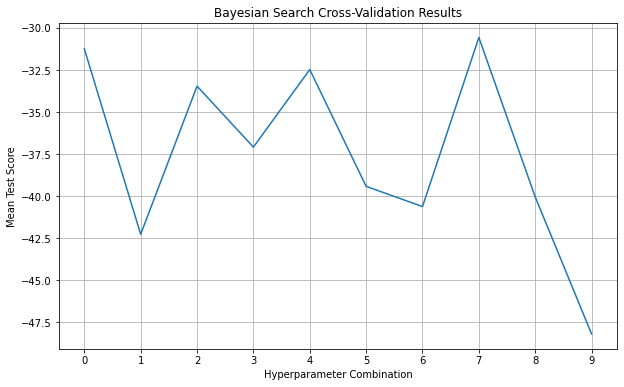

In [74]:
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
sicilia_bayes_adj_R, sicilia_bayes_rmse, sicilia_bayes_mae, sicilia_bayes_accuracy = eval_metrics(test_y_sicilia, sicilia_bayes_pred, sicilia_meta_features)

# Print the results
print("Adjusted R-squared:", sicilia_bayes_adj_R)
print("RMSE:", sicilia_bayes_rmse)
print("Mean Absolute Error:", sicilia_bayes_mae)
print("Accuracy:", sicilia_bayes_accuracy, "%")

# Get the cv_results_ from the BayesSearchCV
sicilia_bayes_results = sicilia_bayes_opt.cv_results_

# Convert cv_results to a Pandas DataFrame
sicilia_bayes_results_df = pd.DataFrame(sicilia_bayes_results)

# Create a line plot to visualize the mean scores for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.plot(sicilia_bayes_results_df.index, sicilia_bayes_results_df['mean_test_score'])
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Bayesian Search Cross-Validation Results')
plt.xticks(sicilia_bayes_results_df.index)
plt.grid(True)
plt.show()

### Genetic Algorithm

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'idx' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Generation 1, RMSE: 9.14, MAE: 0.32, Accuracy: 68.04
Generation 2, RMSE: 4.54, MAE: 0.17, Accuracy: 82.92
Generation 3, RMSE: 4.54, MAE: 0.17, Accuracy: 82.92
Generation 4, RMSE: 4.54, MAE: 0.17, Accuracy: 82.92
Generation 5, RMSE: 4.54, MAE: 0.17, Accuracy: 82.92
Generation 6, RMSE: 5.06, MAE: 0.19, Accuracy: 81.34
Generation 7, RMSE: 4.96, MAE: 0.18, Accuracy: 81.74
Generation 8, RMSE: 4.9, MAE: 0.18, Accuracy: 81.72
Generation 9, RMSE: 4.9, MAE: 0.18, Accuracy: 81.72
Generation 10, RMSE: 4.69, MAE: 0.17, Accuracy: 82.87
Generation 11, RMSE: 4.7, MAE: 0.17, Accuracy: 82.93
Generation 12, RMSE: 4.87, MAE: 0.18, Accuracy: 82.04
Generation 13, RMSE: 4.7, MAE: 0.17, Accuracy: 82.93
Generation 14, RMSE: 4.57, MAE: 0.17, Accuracy: 82.99
Generation 15, RMSE: 4.51, MAE: 0.17, Accuracy: 83.22
Generation 16, RMSE: 4.49, MAE: 0.17, Accuracy: 83.38
Generation 17, RMSE: 4.53, MAE: 0.17, Accuracy: 83.4
Generation 18, RMSE: 4.39, MAE: 0.16, Accuracy: 83.79
Generation 19, RMSE: 4.89, MAE: 0.18, Accu

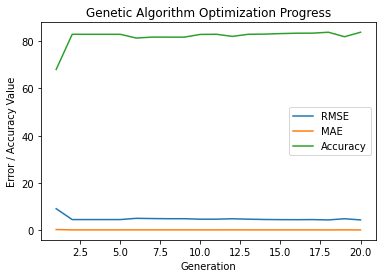

In [75]:
# optimize_GA function running
best_GAmodel_sicilia = optimize_GA(sicilia_meta_features, test_y_sicilia)

In [76]:
# Use the best model 
best_GAmodel_sicilia.fit(sicilia_meta_features, test_y_sicilia)
sicilia_GA_pred = best_GAmodel_sicilia.predict(sicilia_meta_features)
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
sicilia_GA_adj_R, sicilia_GA_rmse, sicilia_GA_mae, sicilia_GA_accuracy = eval_metrics(test_y_sicilia, sicilia_GA_pred, sicilia_meta_features)
# Print the results
print("Adjusted R-squared:", sicilia_GA_adj_R)
print("RMSE:", sicilia_GA_rmse)
print("Mean Absolute Error:", sicilia_GA_mae)
print("Accuracy:", sicilia_GA_accuracy, "%")

Adjusted R-squared: 0.77
RMSE: 4.39
Mean Absolute Error: 0.16
Accuracy: 83.79 %


## trentino

In [78]:
# Data Import
trentino_df = pd.read_csv('trentino_df.csv')

nbhd_cleansed_encoder(trentino_df)

# Create a new column called 'distance_from_centre'
# Official location of the city
trentino_latitude = 46.066666
trentino_longitude = 11.116667

# Calculate the distance between each property location and the city centre
trentino_df['distance_from_centre'] = trentino_df.apply(lambda row: haversine_distance(trentino_latitude, trentino_longitude, row['latitude'], row['longitude']), axis=1)
trentino_df['distance_from_centre']

0       46.499486
1       46.263405
2       27.721161
3       27.729445
4       13.637290
          ...    
7145    55.955992
7146    56.097450
7147    39.135231
7148    37.495628
7149    37.970875
Name: distance_from_centre, Length: 7150, dtype: float64

In [79]:
trentino_annual = trentino_df.drop(['latitude', 'longitude'], axis=1)
trentino_annual.head()

,neighborhood_overview,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,room_type,accommodates,bedrooms,beds,amenities,minimum_nights,maximum_nights,has_availability,availability_30,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,license,instant_bookable,reviews_per_month,profitability_by_numOfYears,host_loc2,email,phone,work_email,bathroom_num,bathroom_type,property_type_encoded,neighbourhood_cleansed_encoded,distance_from_centre
0,0,1,1.0,76.0,99.0,0,194.0,3,4,1.0,2.0,14,1,1125,1,30,84,196,0,0,0,-1.00,0,1,-1.00,32.99,1,1,1,0,1.0,-1.0,25,0,46.499486
1,1,1,3.0,100.0,70.0,0,9.0,3,6,1.0,4.0,16,4,1125,1,28,67,207,7,3,0,4.80,0,0,0.07,27.23,1,1,1,1,1.0,-1.0,25,0,46.263405
2,1,1,3.0,100.0,100.0,0,319.0,3,2,1.0,1.0,19,28,28,1,22,71,329,3,1,0,4.67,0,1,0.18,38.25,0,1,1,0,1.0,-1.0,20,0,27.721161
3,1,1,3.0,100.0,100.0,0,319.0,3,6,3.0,5.0,17,28,28,1,14,56,265,5,3,0,4.80,0,1,0.20,40.84,0,1,1,0,2.0,-1.0,20,0,27.729445
4,1,1,3.0,96.0,100.0,0,98.0,3,4,2.0,3.0,15,28,28,1,0,0,0,0,0,0,-1.00,0,1,-1.00,33.15,0,1,1,0,1.0,-1.0,25,0,13.637290


In [80]:
# Pop and Insert for devision of x and y
first_column = trentino_annual.pop('profitability_by_numOfYears')
trentino_annual.insert(0, 'profitability_by_numOfYears', first_column)
x_trentino = trentino_annual.iloc[:, 2: ]
y_trentino = trentino_annual.iloc[:, 0: 1]

# train / test split
train_x_trentino, test_x_trentino, train_y_trentino, test_y_trentino = train_test_split(x_trentino, y_trentino, test_size = 0.25, random_state = 123)

# Assuming y is a DataFrame, convert it to a numpy array and then ravel
train_y_trentino = train_y_trentino.values.ravel()
test_y_trentino = test_y_trentino.values.ravel()

print('Training Features Shape:', train_x_trentino.shape)
print('Training Labels Shape:', train_y_trentino.shape)
print('Testing Features Shape:', test_x_trentino.shape)
print('Testing Labels Shape:', test_y_trentino.shape)

Training Features Shape: (5362, 33)
Training Labels Shape: (5362,)
Testing Features Shape: (1788, 33)
Testing Labels Shape: (1788,)


### Random Forest

Best Score: 0.9561590507779132
Adjusted R-squared: 0.65
RMSE: 5.24
Mean Absolute Error: 0.17
Accuracy: 83.05 %


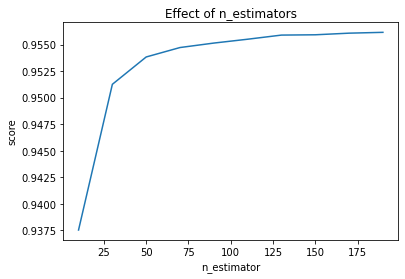

In [81]:
model = RandomForestRegressor() 

# Use the effect_estimators function to get the best model, predictions, and best score
trentino_rf_model, trentino_rf_pred, trentino_rf_score = effect_estimators(train_x_trentino, train_y_trentino, test_x_trentino)
print("Best Score:", trentino_rf_score)

# Call the eval_metrics function and store the results in variables
trentino_rf_adj_R, trentino_rf_rmse, trentino_rf_mae, trentino_rf_accuracy = eval_metrics(test_y_trentino, trentino_rf_pred, train_x_trentino)

# Print the results
print("Adjusted R-squared:", trentino_rf_adj_R)
print("RMSE:", trentino_rf_rmse)
print("Mean Absolute Error:", trentino_rf_mae)
print("Accuracy:", trentino_rf_accuracy, "%")

### Gradient Boosting

Best Score: 0.7218654292410718

Adjusted R-squared: 0.6
RMSE: 5.64
Mean Absolute Error: 0.19
Accuracy: 81.11 %


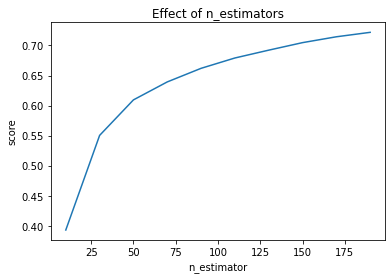

In [82]:
model = GradientBoostingRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
trentino_gb_model, trentino_gb_pred, trentino_gb_score = effect_estimators(train_x_trentino, train_y_trentino, test_x_trentino)
print("Best Score:", trentino_gb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
trentino_gb_adj_R, trentino_gb_rmse, trentino_gb_mae, trentino_gb_accuracy = eval_metrics(test_y_trentino, trentino_gb_pred, train_x_trentino)

# Print the results
print("Adjusted R-squared:", trentino_gb_adj_R)
print("RMSE:", trentino_gb_rmse)
print("Mean Absolute Error:", trentino_gb_mae)
print("Accuracy:", trentino_gb_accuracy, "%")

### Light GBM

Best Score: 0.9064820526869082

Adjusted R-squared: 0.65
RMSE: 5.26
Mean Absolute Error: 0.17
Accuracy: 82.92 %


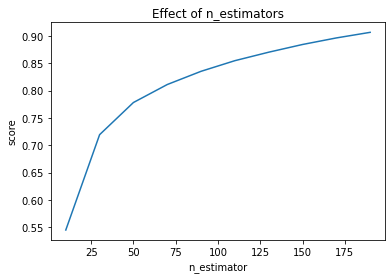

In [83]:
model = lgb.LGBMRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
trentino_lgb_model, trentino_lgb_pred, trentino_lgb_score = effect_estimators(train_x_trentino, train_y_trentino, test_x_trentino)
print("Best Score:", trentino_lgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
trentino_lgb_adj_R, trentino_lgb_rmse, trentino_lgb_mae, trentino_lgb_accuracy = eval_metrics(test_y_trentino, trentino_lgb_pred, train_x_trentino)

# Print the results
print("Adjusted R-squared:", trentino_lgb_adj_R)
print("RMSE:", trentino_lgb_rmse)
print("Mean Absolute Error:", trentino_lgb_mae)
print("Accuracy:", trentino_lgb_accuracy, "%")

### XGBoost

Best Score: 0.9871447489020179

Adjusted R-squared: 0.63
RMSE: 5.39
Mean Absolute Error: 0.18
Accuracy: 82.4 %


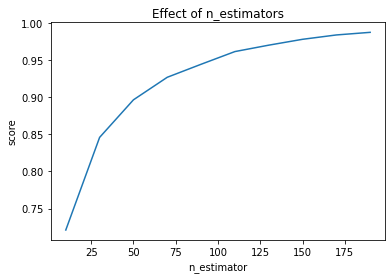

In [84]:
model = xgb.XGBRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
trentino_xgb_model, trentino_xgb_pred, trentino_xgb_score = effect_estimators(train_x_trentino, train_y_trentino, test_x_trentino)
print("Best Score:", trentino_xgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
trentino_xgb_adj_R, trentino_xgb_rmse, trentino_xgb_mae, trentino_xgb_accuracy = eval_metrics(test_y_trentino, trentino_xgb_pred, train_x_trentino)

# Print the results
print("Adjusted R-squared:", trentino_xgb_adj_R)
print("RMSE:", trentino_xgb_rmse)
print("Mean Absolute Error:", trentino_xgb_mae)
print("Accuracy:", trentino_xgb_accuracy, "%")

                    Variable  Importance
0                  host_loc2    0.269244
1  host_total_listings_count    0.151739
2           instant_bookable    0.082655
3          number_of_reviews    0.043648
4               bathroom_num    0.041401
5      property_type_encoded    0.038669
6          host_is_superhost    0.036759
7             maximum_nights    0.023557
8                      email    0.023207
9          reviews_per_month    0.023115


<AxesSubplot:title={'center':'XGBoost Importance of Trentino'}, xlabel='Importance', ylabel='Variable'>

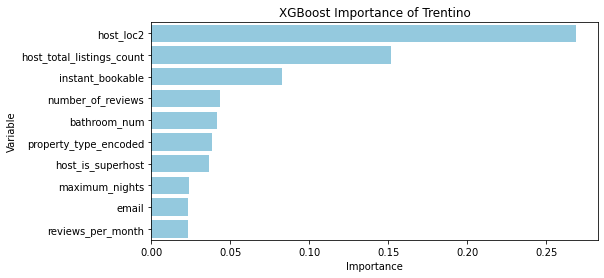

In [85]:
trentino_xgb_10top = important_features(trentino_xgb_model, x_trentino)
print(trentino_xgb_10top)

plt.figure(figsize=(8,4))
plt.title('XGBoost Importance of Trentino')
sns.barplot(y='Variable', x='Importance', data=trentino_xgb_10top, color='skyblue')

### Ensemble Stacking

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Best Score: 0.990717849567924

Adjusted R-squared: 0.99
RMSE: 0.87
Mean Absolute Error: 0.03
Accuracy: 97.2 %


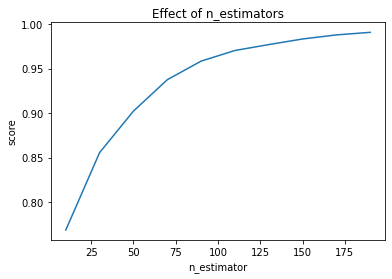

In [86]:
model = xgb.XGBRegressor()   
# Create a new feature matrix with base learners' predictions as meta-features
trentino_meta_features = np.column_stack((trentino_rf_pred, trentino_gb_pred, trentino_lgb_pred))

# Use the effect_estimators function to get the best model, predictions, and best score
trentino_stack_model, trentino_stack_pred, trentino_stack_score = effect_estimators(trentino_meta_features, test_y_trentino, trentino_meta_features)

print(trentino_stack_model)
print()
print("Best Score:", trentino_stack_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
trentino_stack_adj_R, trentino_stack_rmse, trentino_stack_mae, trentino_stack_accuracy = eval_metrics(test_y_trentino, trentino_stack_pred, trentino_meta_features)

# Print the results
print("Adjusted R-squared:", trentino_stack_adj_R)
print("RMSE:", trentino_stack_rmse)
print("Mean Absolute Error:", trentino_stack_mae)
print("Accuracy:", trentino_stack_accuracy, "%")

### Bayesian optimisation

In [87]:
# Meta Learner
trentino_meta_learner = xgb.XGBRegressor(n_estimators=100, random_state=123)

# Perform Bayesian Search for the meta-learner
trentino_bayes_opt = BayesSearchCV(trentino_meta_learner, bayes_search, n_iter=10, cv=10, 
                         scoring="neg_mean_squared_error", verbose=4, random_state=123) 

# Fit the optimized meta-learner on the meta-features
trentino_bayes_opt.fit(trentino_meta_features, test_y_trentino)

# Make predictions using the meta-learner on the test data
trentino_bayes_pred = trentino_bayes_opt.predict(trentino_meta_features)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-37.121 total time=   0.9s
[CV 2/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-39.657 total time=   0.9s
[CV 3/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-33.096 total time=   0.9s
[CV 4/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-30.872 total time=   0.8s
[CV 5/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-36.826 total time=   0.9s
[CV 6/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-31.160 total time=   0.8s
[CV 7/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimator

[CV 8/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-38.005 total time=   2.3s
[CV 9/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-35.233 total time=   2.5s
[CV 10/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-48.616 total time=   2.5s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-37.187 total time=   1.9s
[CV 2/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-42.092 total time=   1.7s
[CV 3/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-32.932 total time=   1.7s
[CV 4/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183

In [88]:
# Access the best results
print("Best MSE Score:", -trentino_bayes_opt.best_score_)
print("Best Parameters:", trentino_bayes_opt.best_params_)

Best MSE Score: 33.8312749074921
Best Parameters: OrderedDict([('gamma', 0.7703399241440627), ('learning_rate', 0.19204784774815406), ('max_depth', 2), ('n_estimators', 764)])


Adjusted R-squared: 0.89
RMSE: 2.97
Mean Absolute Error: 0.1
Accuracy: 89.73 %


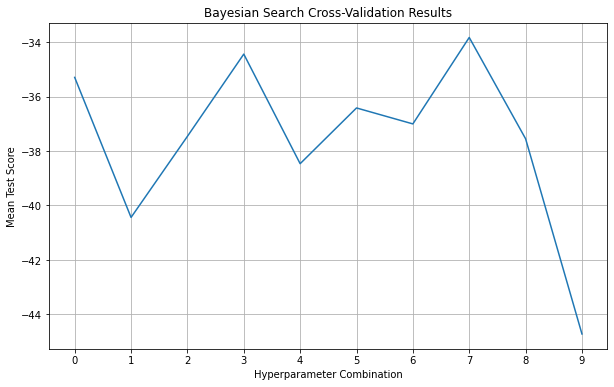

In [89]:
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
trentino_bayes_adj_R, trentino_bayes_rmse, trentino_bayes_mae, trentino_bayes_accuracy = eval_metrics(test_y_trentino, trentino_bayes_pred, trentino_meta_features)

# Print the results
print("Adjusted R-squared:", trentino_bayes_adj_R)
print("RMSE:", trentino_bayes_rmse)
print("Mean Absolute Error:", trentino_bayes_mae)
print("Accuracy:", trentino_bayes_accuracy, "%")

# Get the cv_results_ from the BayesSearchCV
trentino_bayes_results = trentino_bayes_opt.cv_results_

# Convert cv_results to a Pandas DataFrame
trentino_bayes_results_df = pd.DataFrame(trentino_bayes_results)

# Create a line plot to visualize the mean scores for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.plot(trentino_bayes_results_df.index, trentino_bayes_results_df['mean_test_score'])
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Bayesian Search Cross-Validation Results')
plt.xticks(trentino_bayes_results_df.index)
plt.grid(True)
plt.show()

### Genetic Algorithm

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'idx' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Generation 1, RMSE: 9.0, MAE: 0.31, Accuracy: 69.29
Generation 2, RMSE: 8.99, MAE: 0.31, Accuracy: 68.61
Generation 3, RMSE: 5.33, MAE: 0.16, Accuracy: 84.03
Generation 4, RMSE: 3.7, MAE: 0.12, Accuracy: 87.7
Generation 5, RMSE: 2.19, MAE: 0.07, Accuracy: 93.11
Generation 6, RMSE: 2.19, MAE: 0.07, Accuracy: 93.11
Generation 7, RMSE: 4.29, MAE: 0.14, Accuracy: 85.59
Generation 8, RMSE: 3.29, MAE: 0.11, Accuracy: 88.84
Generation 9, RMSE: 3.29, MAE: 0.11, Accuracy: 88.84
Generation 10, RMSE: 3.22, MAE: 0.11, Accuracy: 89.35
Generation 11, RMSE: 3.07, MAE: 0.1, Accuracy: 90.43
Generation 12, RMSE: 2.83, MAE: 0.09, Accuracy: 90.75
Generation 13, RMSE: 3.63, MAE: 0.12, Accuracy: 87.76
Generation 14, RMSE: 4.39, MAE: 0.15, Accuracy: 85.18
Generation 15, RMSE: 2.86, MAE: 0.1, Accuracy: 90.44
Generation 16, RMSE: 2.64, MAE: 0.09, Accuracy: 91.47
Generation 17, RMSE: 2.95, MAE: 0.1, Accuracy: 90.32
Generation 18, RMSE: 2.95, MAE: 0.1, Accuracy: 90.32
Generation 19, RMSE: 2.02, MAE: 0.06, Accura

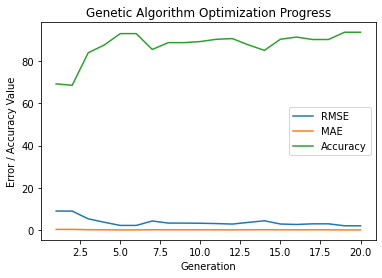

In [90]:
# Usage example for Trentino dataset
best_GAmodel_trentino = optimize_GA(trentino_meta_features, test_y_trentino)

In [91]:
# Use the best model 
best_GAmodel_trentino.fit(trentino_meta_features, test_y_trentino)
trentino_GA_pred = best_GAmodel_trentino.predict(trentino_meta_features)
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
trentino_GA_adj_R, trentino_GA_rmse, trentino_GA_mae, trentino_GA_accuracy = eval_metrics(test_y_trentino, trentino_GA_pred, trentino_meta_features)
# Print the results
print("Adjusted R-squared:", trentino_GA_adj_R)
print("RMSE:", trentino_GA_rmse)
print("Mean Absolute Error:", trentino_GA_mae)
print("Accuracy:", trentino_GA_accuracy, "%")

Adjusted R-squared: 0.95
RMSE: 2.02
Mean Absolute Error: 0.06
Accuracy: 93.76 %


## puglia

In [93]:
# Data Import
puglia_df = pd.read_csv('puglia_df.csv')

nbhd_cleansed_encoder(puglia_df)

# Create a new column called 'distance_from_centre'
# Official location of the city
puglia_latitude = 41.125278
puglia_longitude = 16.866667

# Calculate the distance between each property location and the city centre
puglia_df['distance_from_centre'] = puglia_df.apply(lambda row: haversine_distance(puglia_latitude, puglia_longitude, row['latitude'], row['longitude']), axis=1)
puglia_df['distance_from_centre']

0        168.023087
1         99.627277
2        104.963352
3         65.736226
4         74.037693
            ...    
41365    121.169487
41366     59.387177
41367     59.653661
41368    111.020866
41369     59.703294
Name: distance_from_centre, Length: 41370, dtype: float64

In [94]:
puglia_annual = puglia_df.drop(['latitude', 'longitude'], axis=1)
puglia_annual.head()

,neighborhood_overview,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,room_type,accommodates,bedrooms,beds,amenities,minimum_nights,maximum_nights,has_availability,availability_30,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,license,instant_bookable,reviews_per_month,profitability_by_numOfYears,host_loc2,email,phone,work_email,bathroom_num,bathroom_type,property_type_encoded,neighbourhood_cleansed_encoded,distance_from_centre
0,1,0,-1.0,-1.0,-1.0,0,2.0,3,6,2.0,5.0,17,5,30,1,0,1,74,2,0,0,4.5,0,0,0.03,16.34,1,1,1,0,1.0,-1.0,25,150,168.023087
1,0,0,3.0,100.0,20.0,0,3.0,3,5,2.0,5.0,27,5,1125,1,23,83,358,1,0,0,3.0,0,0,0.03,16.96,1,1,1,0,2.0,-1.0,13,244,99.627277
2,0,1,-1.0,-1.0,-1.0,0,220.0,3,4,1.0,1.0,9,1,1125,1,0,0,0,0,0,0,-1.0,0,1,-1.00,34.87,0,1,1,0,1.0,-1.0,20,244,104.963352
3,0,1,-1.0,-1.0,-1.0,0,220.0,3,2,1.0,1.0,9,1,1125,1,0,0,0,0,0,0,-1.0,0,1,-1.00,35.36,0,1,1,0,1.0,-1.0,20,61,65.736226
4,0,1,-1.0,-1.0,-1.0,0,220.0,3,5,3.0,3.0,11,1,1125,1,0,0,0,0,0,0,-1.0,0,1,-1.00,43.24,0,1,1,0,2.0,-1.0,31,149,74.037693


In [95]:
# Pop and Insert for devision of x and y
first_column = puglia_annual.pop('profitability_by_numOfYears')
puglia_annual.insert(0, 'profitability_by_numOfYears', first_column)
x_puglia = puglia_annual.iloc[:, 2: ]
y_puglia = puglia_annual.iloc[:, 0: 1]

# train / test split
train_x_puglia, test_x_puglia, train_y_puglia, test_y_puglia = train_test_split(x_puglia, y_puglia, test_size = 0.25, random_state = 123)

# Assuming y is a DataFrame, convert it to a numpy array and then ravel
train_y_puglia = train_y_puglia.values.ravel()
test_y_puglia = test_y_puglia.values.ravel()

print('Training Features Shape:', train_x_puglia.shape)
print('Training Labels Shape:', train_y_puglia.shape)
print('Testing Features Shape:', test_x_puglia.shape)
print('Testing Labels Shape:', test_y_puglia.shape)

Training Features Shape: (31027, 33)
Training Labels Shape: (31027,)
Testing Features Shape: (10343, 33)
Testing Labels Shape: (10343,)


### Random Forest

Best Score: 0.9445722776796399
Adjusted R-squared: 0.6
RMSE: 5.55
Mean Absolute Error: 0.19
Accuracy: 80.7 %


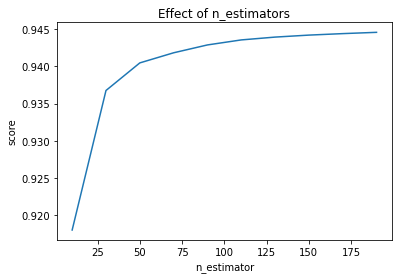

In [96]:
model = RandomForestRegressor() 

# Use the effect_estimators function to get the best model, predictions, and best score
puglia_rf_model, puglia_rf_pred, puglia_rf_score = effect_estimators(train_x_puglia, train_y_puglia, test_x_puglia)
print("Best Score:", puglia_rf_score)

# Call the eval_metrics function and store the results in variables
puglia_rf_adj_R, puglia_rf_rmse, puglia_rf_mae, puglia_rf_accuracy = eval_metrics(test_y_puglia, puglia_rf_pred, train_x_puglia)

# Print the results
print("Adjusted R-squared:", puglia_rf_adj_R)
print("RMSE:", puglia_rf_rmse)
print("Mean Absolute Error:", puglia_rf_mae)
print("Accuracy:", puglia_rf_accuracy, "%")

### Gradient Boosting

Best Score: 0.5448505220285083

Adjusted R-squared: 0.53
RMSE: 6.03
Mean Absolute Error: 0.21
Accuracy: 78.58 %


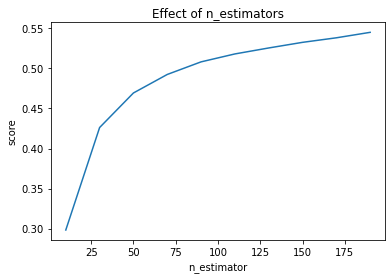

In [97]:
model = GradientBoostingRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
puglia_gb_model, puglia_gb_pred, puglia_gb_score = effect_estimators(train_x_puglia, train_y_puglia, test_x_puglia)
print("Best Score:", puglia_gb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
puglia_gb_adj_R, puglia_gb_rmse, puglia_gb_mae, puglia_gb_accuracy = eval_metrics(test_y_puglia, puglia_gb_pred, train_x_puglia)

# Print the results
print("Adjusted R-squared:", puglia_gb_adj_R)
print("RMSE:", puglia_gb_rmse)
print("Mean Absolute Error:", puglia_gb_mae)
print("Accuracy:", puglia_gb_accuracy, "%")

### Light GBM

Best Score: 0.68349341937556

Adjusted R-squared: 0.6
RMSE: 5.57
Mean Absolute Error: 0.19
Accuracy: 80.53 %


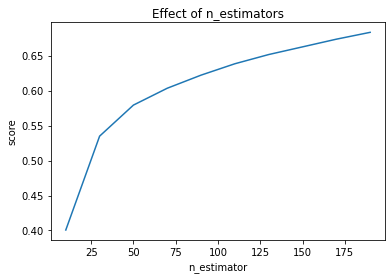

In [98]:
model = lgb.LGBMRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
puglia_lgb_model, puglia_lgb_pred, puglia_lgb_score = effect_estimators(train_x_puglia, train_y_puglia, test_x_puglia)
print("Best Score:", puglia_lgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
puglia_lgb_adj_R, puglia_lgb_rmse, puglia_lgb_mae, puglia_lgb_accuracy = eval_metrics(test_y_puglia, puglia_lgb_pred, train_x_puglia)

# Print the results
print("Adjusted R-squared:", puglia_lgb_adj_R)
print("RMSE:", puglia_lgb_rmse)
print("Mean Absolute Error:", puglia_lgb_mae)
print("Accuracy:", puglia_lgb_accuracy, "%")

### XGBoost

Best Score: 0.8173277616400458

Adjusted R-squared: 0.61
RMSE: 5.52
Mean Absolute Error: 0.19
Accuracy: 80.78 %


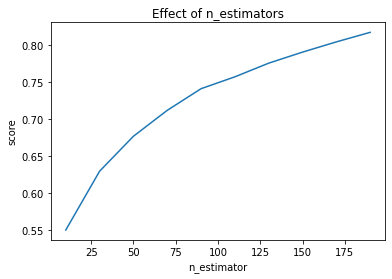

In [99]:
model = xgb.XGBRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
puglia_xgb_model, puglia_xgb_pred, puglia_xgb_score = effect_estimators(train_x_puglia, train_y_puglia, test_x_puglia)
print("Best Score:", puglia_xgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
puglia_xgb_adj_R, puglia_xgb_rmse, puglia_xgb_mae, puglia_xgb_accuracy = eval_metrics(test_y_puglia, puglia_xgb_pred, train_x_puglia)

# Print the results
print("Adjusted R-squared:", puglia_xgb_adj_R)
print("RMSE:", puglia_xgb_rmse)
print("Mean Absolute Error:", puglia_xgb_mae)
print("Accuracy:", puglia_xgb_accuracy, "%")

                    Variable  Importance
0                  host_loc2    0.278480
1               bathroom_num    0.109975
2           instant_bookable    0.063727
3          number_of_reviews    0.060658
4  host_total_listings_count    0.050152
5                  room_type    0.032386
6                   bedrooms    0.031936
7             maximum_nights    0.028579
8          reviews_per_month    0.028268
9                      email    0.026157


<AxesSubplot:title={'center':'XGBoost Importance of Puglia'}, xlabel='Importance', ylabel='Variable'>

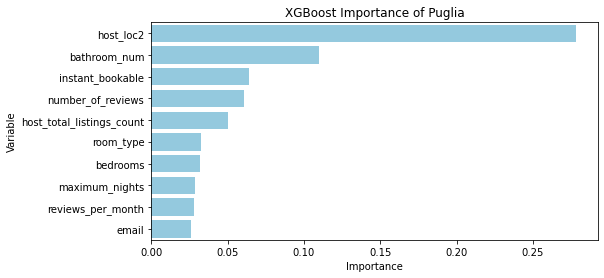

In [100]:
puglia_xgb_10top = important_features(puglia_xgb_model, x_puglia)
print(puglia_xgb_10top)

plt.figure(figsize=(8,4))
plt.title('XGBoost Importance of Puglia')
sns.barplot(y='Variable', x='Importance', data=puglia_xgb_10top, color='skyblue')

### Ensemble Stacking

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Best Score: 0.8568958552224308

Adjusted R-squared: 0.86
RMSE: 3.33
Mean Absolute Error: 0.12
Accuracy: 88.17 %


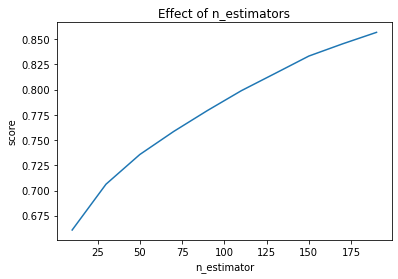

In [101]:
model = xgb.XGBRegressor()   
# Create a new feature matrix with base learners' predictions as meta-features
puglia_meta_features = np.column_stack((puglia_rf_pred, puglia_gb_pred, puglia_lgb_pred))

# Use the effect_estimators function to get the best model, predictions, and best score
puglia_stack_model, puglia_stack_pred, puglia_stack_score = effect_estimators(puglia_meta_features, test_y_puglia, puglia_meta_features)

print(puglia_stack_model)
print()
print("Best Score:", puglia_stack_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
puglia_stack_adj_R, puglia_stack_rmse, puglia_stack_mae, puglia_stack_accuracy = eval_metrics(test_y_puglia, puglia_stack_pred, puglia_meta_features)

# Print the results
print("Adjusted R-squared:", puglia_stack_adj_R)
print("RMSE:", puglia_stack_rmse)
print("Mean Absolute Error:", puglia_stack_mae)
print("Accuracy:", puglia_stack_accuracy, "%")

### Bayesian optimisation

In [102]:
# Meta Learner
puglia_meta_learner = xgb.XGBRegressor(n_estimators=100, random_state=123)

# Perform Bayesian Search for the meta-learner
puglia_bayes_opt = BayesSearchCV(puglia_meta_learner, bayes_search, n_iter=10, cv=10, 
                         scoring="neg_mean_squared_error", verbose=4, random_state=123) 

# Fit the optimized meta-learner on the meta-features
puglia_bayes_opt.fit(puglia_meta_features, test_y_puglia)

# Make predictions using the meta-learner on the test data
puglia_bayes_pred = puglia_bayes_opt.predict(puglia_meta_features)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-30.448 total time=   3.0s
[CV 2/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-31.879 total time=   2.9s
[CV 3/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-32.186 total time=   2.9s
[CV 4/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-31.443 total time=   2.8s
[CV 5/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-29.836 total time=   2.9s
[CV 6/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-31.589 total time=   2.8s
[CV 7/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimator

[CV 8/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-37.981 total time=  10.1s
[CV 9/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-42.811 total time=  10.2s
[CV 10/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-40.807 total time=  10.5s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-37.153 total time=   7.1s
[CV 2/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-40.370 total time=   7.4s
[CV 3/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-42.351 total time=   7.6s
[CV 4/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183

In [103]:
# Access the best results
print("Best MSE Score:", -puglia_bayes_opt.best_score_)
print("Best Parameters:", puglia_bayes_opt.best_params_)

Best MSE Score: 30.873790994563734
Best Parameters: OrderedDict([('gamma', 0.7703399241440627), ('learning_rate', 0.19204784774815406), ('max_depth', 2), ('n_estimators', 764)])


Adjusted R-squared: 0.71
RMSE: 4.74
Mean Absolute Error: 0.17
Accuracy: 83.35 %


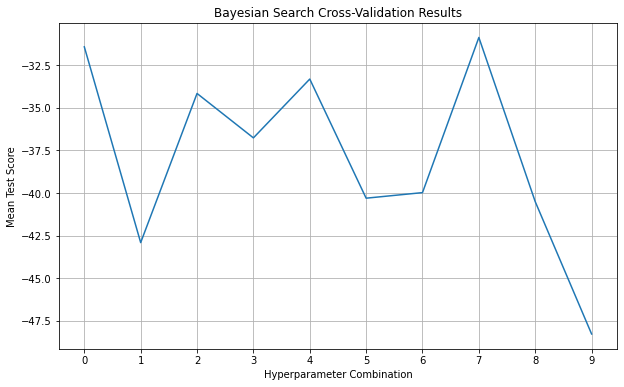

In [104]:
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
puglia_bayes_adj_R, puglia_bayes_rmse, puglia_bayes_mae, puglia_bayes_accuracy = eval_metrics(test_y_puglia, puglia_bayes_pred, puglia_meta_features)

# Print the results
print("Adjusted R-squared:", puglia_bayes_adj_R)
print("RMSE:", puglia_bayes_rmse)
print("Mean Absolute Error:", puglia_bayes_mae)
print("Accuracy:", puglia_bayes_accuracy, "%")

# Get the cv_results_ from the BayesSearchCV
puglia_bayes_results = puglia_bayes_opt.cv_results_

# Convert cv_results to a Pandas DataFrame
puglia_bayes_results_df = pd.DataFrame(puglia_bayes_results)

# Create a line plot to visualize the mean scores for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.plot(puglia_bayes_results_df.index, puglia_bayes_results_df['mean_test_score'])
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Bayesian Search Cross-Validation Results')
plt.xticks(puglia_bayes_results_df.index)
plt.grid(True)
plt.show()

### Genetic Algorithm

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'idx' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Generation 1, RMSE: 8.8, MAE: 0.32, Accuracy: 67.62
Generation 2, RMSE: 8.8, MAE: 0.32, Accuracy: 67.62
Generation 3, RMSE: 8.8, MAE: 0.32, Accuracy: 67.62
Generation 4, RMSE: 8.8, MAE: 0.32, Accuracy: 67.62
Generation 5, RMSE: 5.21, MAE: 0.17, Accuracy: 83.45
Generation 6, RMSE: 4.88, MAE: 0.17, Accuracy: 83.3
Generation 7, RMSE: 5.04, MAE: 0.17, Accuracy: 83.32
Generation 8, RMSE: 5.39, MAE: 0.19, Accuracy: 81.5
Generation 9, RMSE: 5.39, MAE: 0.19, Accuracy: 81.5
Generation 10, RMSE: 4.47, MAE: 0.15, Accuracy: 84.54
Generation 11, RMSE: 4.47, MAE: 0.15, Accuracy: 84.54
Generation 12, RMSE: 5.21, MAE: 0.17, Accuracy: 83.45
Generation 13, RMSE: 4.68, MAE: 0.16, Accuracy: 83.74
Generation 14, RMSE: 4.6, MAE: 0.16, Accuracy: 83.8
Generation 15, RMSE: 4.6, MAE: 0.16, Accuracy: 83.8
Generation 16, RMSE: 4.6, MAE: 0.16, Accuracy: 83.8
Generation 17, RMSE: 4.59, MAE: 0.16, Accuracy: 84.1
Generation 18, RMSE: 4.54, MAE: 0.16, Accuracy: 84.3
Generation 19, RMSE: 4.6, MAE: 0.16, Accuracy: 83.8


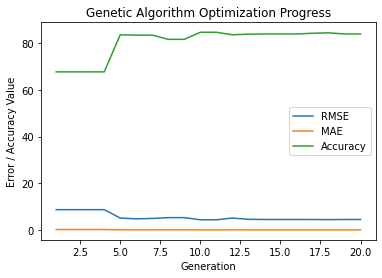

In [105]:
# Usage example for Puglia dataset
best_GAmodel_puglia = optimize_GA(puglia_meta_features, test_y_puglia)

In [106]:
# Use the best model 
best_GAmodel_puglia.fit(puglia_meta_features, test_y_puglia)
puglia_GA_pred = best_GAmodel_puglia.predict(puglia_meta_features)
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
puglia_GA_adj_R, puglia_GA_rmse, puglia_GA_mae, puglia_GA_accuracy = eval_metrics(test_y_puglia, puglia_GA_pred, puglia_meta_features)
# Print the results
print("Adjusted R-squared:", puglia_GA_adj_R)
print("RMSE:", puglia_GA_rmse)
print("Mean Absolute Error:", puglia_GA_mae)
print("Accuracy:", puglia_GA_accuracy, "%")

Adjusted R-squared: 0.74
RMSE: 4.47
Mean Absolute Error: 0.15
Accuracy: 84.54 %


## firenze

In [108]:
# Data Import
firenze_df = pd.read_csv('firenze_df.csv')

nbhd_cleansed_encoder(firenze_df)

# Create a new column called 'distance_from_centre'
# Official location of the city
firenze_latitude = 43.769562
firenze_longitude = 11.255814

# Calculate the distance between each property location and the city centre
firenze_df['distance_from_centre'] = firenze_df.apply(lambda row: haversine_distance(firenze_latitude, firenze_longitude, row['latitude'], row['longitude']), axis=1)
firenze_df['distance_from_centre']

0        5.254324
1        5.259665
2        0.233174
3        5.150160
4        5.243565
           ...   
11133    7.402731
11134    6.014047
11135    5.367636
11136    6.055857
11137    7.128188
Name: distance_from_centre, Length: 11138, dtype: float64

In [109]:
firenze_annual = firenze_df.drop(['latitude', 'longitude'], axis=1)
firenze_annual.head()

,neighborhood_overview,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,room_type,accommodates,bedrooms,beds,amenities,minimum_nights,maximum_nights,has_availability,availability_30,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,license,instant_bookable,reviews_per_month,profitability_by_numOfYears,host_loc2,email,phone,work_email,bathroom_num,bathroom_type,property_type_encoded,neighbourhood_cleansed_encoded,distance_from_centre
0,0,1,-1.0,-1.0,-1.0,0,220.0,3,2,1.0,1.0,10,1,1125,1,0,0,0,0,0,0,-1.0,0,1,-1.0,40.48,0,1,1,0,1.0,-1.0,20,2,5.254324
1,0,1,-1.0,-1.0,-1.0,0,220.0,3,4,2.0,3.0,10,1,1125,1,0,0,0,0,0,0,-1.0,0,1,-1.0,43.66,0,1,1,0,2.0,-1.0,20,2,5.259665
2,0,1,-1.0,-1.0,-1.0,0,220.0,3,8,3.0,6.0,7,1,1125,1,0,0,0,0,0,0,-1.0,0,1,-1.0,47.19,0,1,1,0,2.0,-1.0,25,1,0.233174
3,0,1,-1.0,-1.0,-1.0,0,220.0,3,2,1.0,1.0,12,1,1125,1,0,0,0,0,0,0,-1.0,0,1,-1.0,39.18,0,1,1,0,1.0,-1.0,20,0,5.150160
4,0,1,-1.0,-1.0,-1.0,0,220.0,3,2,1.0,1.0,10,1,1125,1,0,0,0,0,0,0,-1.0,0,1,-1.0,40.48,0,1,1,0,1.0,-1.0,20,2,5.243565


In [110]:
# Pop and Insert for devision of x and y
first_column = firenze_annual.pop('profitability_by_numOfYears')
firenze_annual.insert(0, 'profitability_by_numOfYears', first_column)
x_firenze = firenze_annual.iloc[:, 2: ]
y_firenze = firenze_annual.iloc[:, 0: 1]

# train / test split
train_x_firenze, test_x_firenze, train_y_firenze, test_y_firenze = train_test_split(x_firenze, y_firenze, test_size = 0.25, random_state = 123)

# Assuming y is a DataFrame, convert it to a numpy array and then ravel
train_y_firenze = train_y_firenze.values.ravel()
test_y_firenze = test_y_firenze.values.ravel()

print('Training Features Shape:', train_x_firenze.shape)
print('Training Labels Shape:', train_y_firenze.shape)
print('Testing Features Shape:', test_x_firenze.shape)
print('Testing Labels Shape:', test_y_firenze.shape)

Training Features Shape: (8353, 33)
Training Labels Shape: (8353,)
Testing Features Shape: (2785, 33)
Testing Labels Shape: (2785,)


### Random Forest

Best Score: 0.954621194015889
Adjusted R-squared: 0.69
RMSE: 5.01
Mean Absolute Error: 0.17
Accuracy: 83.16 %


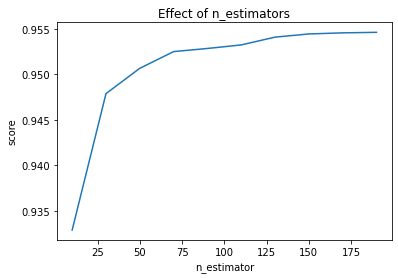

In [111]:
model = RandomForestRegressor() 

# Use the effect_estimators function to get the best model, predictions, and best score
firenze_rf_model, firenze_rf_pred, firenze_rf_score = effect_estimators(train_x_firenze, train_y_firenze, test_x_firenze)
print("Best Score:", firenze_rf_score)

# Call the eval_metrics function and store the results in variables
firenze_rf_adj_R, firenze_rf_rmse, firenze_rf_mae, firenze_rf_accuracy = eval_metrics(test_y_firenze, firenze_rf_pred, train_x_firenze)

# Print the results
print("Adjusted R-squared:", firenze_rf_adj_R)
print("RMSE:", firenze_rf_rmse)
print("Mean Absolute Error:", firenze_rf_mae)
print("Accuracy:", firenze_rf_accuracy, "%")

### Gradient Boosting

Best Score: 0.7023479976905291

Adjusted R-squared: 0.65
RMSE: 5.34
Mean Absolute Error: 0.19
Accuracy: 81.49 %


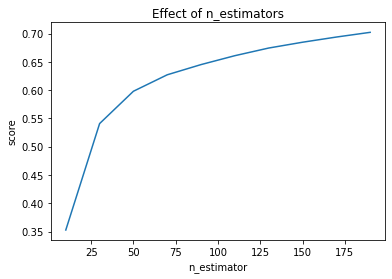

In [112]:
model = GradientBoostingRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
firenze_gb_model, firenze_gb_pred, firenze_gb_score = effect_estimators(train_x_firenze, train_y_firenze, test_x_firenze)
print("Best Score:", firenze_gb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
firenze_gb_adj_R, firenze_gb_rmse, firenze_gb_mae, firenze_gb_accuracy = eval_metrics(test_y_firenze, firenze_gb_pred, train_x_firenze)

# Print the results
print("Adjusted R-squared:", firenze_gb_adj_R)
print("RMSE:", firenze_gb_rmse)
print("Mean Absolute Error:", firenze_gb_mae)
print("Accuracy:", firenze_gb_accuracy, "%")

### Light GBM

Best Score: 0.868160994204858

Adjusted R-squared: 0.69
RMSE: 4.98
Mean Absolute Error: 0.17
Accuracy: 83.07 %


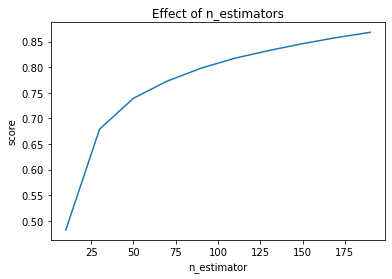

In [113]:
model = lgb.LGBMRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
firenze_lgb_model, firenze_lgb_pred, firenze_lgb_score = effect_estimators(train_x_firenze, train_y_firenze, test_x_firenze)
print("Best Score:", firenze_lgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
firenze_lgb_adj_R, firenze_lgb_rmse, firenze_lgb_mae, firenze_lgb_accuracy = eval_metrics(test_y_firenze, firenze_lgb_pred, train_x_firenze)

# Print the results
print("Adjusted R-squared:", firenze_lgb_adj_R)
print("RMSE:", firenze_lgb_rmse)
print("Mean Absolute Error:", firenze_lgb_mae)
print("Accuracy:", firenze_lgb_accuracy, "%")

### XGBoost

Best Score: 0.9660639424713946

Adjusted R-squared: 0.67
RMSE: 5.15
Mean Absolute Error: 0.17
Accuracy: 82.55 %


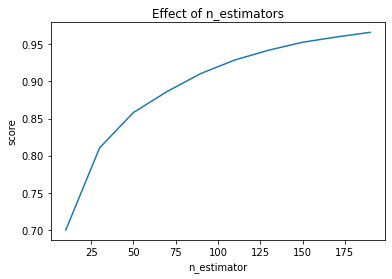

In [114]:
model = xgb.XGBRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
firenze_xgb_model, firenze_xgb_pred, firenze_xgb_score = effect_estimators(train_x_firenze, train_y_firenze, test_x_firenze)
print("Best Score:", firenze_xgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
firenze_xgb_adj_R, firenze_xgb_rmse, firenze_xgb_mae, firenze_xgb_accuracy = eval_metrics(test_y_firenze, firenze_xgb_pred, train_x_firenze)

# Print the results
print("Adjusted R-squared:", firenze_xgb_adj_R)
print("RMSE:", firenze_xgb_rmse)
print("Mean Absolute Error:", firenze_xgb_mae)
print("Accuracy:", firenze_xgb_accuracy, "%")

                    Variable  Importance
0                  host_loc2    0.303679
1               bathroom_num    0.091537
2  host_total_listings_count    0.067186
3                   bedrooms    0.047824
4           instant_bookable    0.047650
5      property_type_encoded    0.035763
6          number_of_reviews    0.031851
7                  room_type    0.030620
8            availability_90    0.027771
9                      email    0.026225


<AxesSubplot:title={'center':'XGBoost Importance of Firenze'}, xlabel='Importance', ylabel='Variable'>

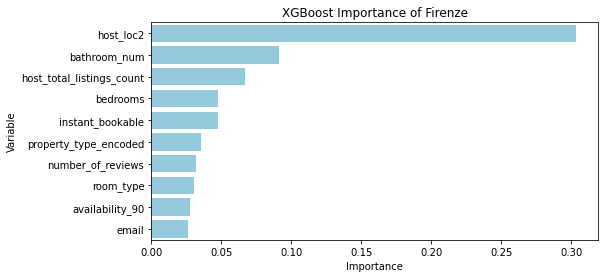

In [115]:
firenze_xgb_10top = important_features(firenze_xgb_model, x_firenze)
print(firenze_xgb_10top)

plt.figure(figsize=(8,4))
plt.title('XGBoost Importance of Firenze')
sns.barplot(y='Variable', x='Importance', data=firenze_xgb_10top, color='skyblue')

### Ensemble Stacking

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Best Score: 0.9746852275327367

Adjusted R-squared: 0.97
RMSE: 1.44
Mean Absolute Error: 0.05
Accuracy: 95.2 %


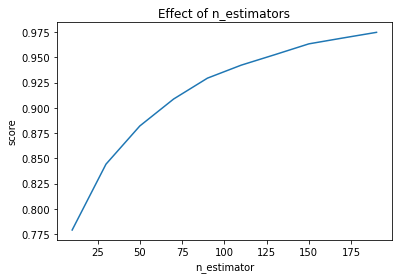

In [116]:
model = xgb.XGBRegressor()   
# Create a new feature matrix with base learners' predictions as meta-features
firenze_meta_features = np.column_stack((firenze_rf_pred, firenze_gb_pred, firenze_lgb_pred))

# Use the effect_estimators function to get the best model, predictions, and best score
firenze_stack_model, firenze_stack_pred, firenze_stack_score = effect_estimators(firenze_meta_features, test_y_firenze, firenze_meta_features)

print(firenze_stack_model)
print()
print("Best Score:", firenze_stack_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
firenze_stack_adj_R, firenze_stack_rmse, firenze_stack_mae, firenze_stack_accuracy = eval_metrics(test_y_firenze, firenze_stack_pred, firenze_meta_features)

# Print the results
print("Adjusted R-squared:", firenze_stack_adj_R)
print("RMSE:", firenze_stack_rmse)
print("Mean Absolute Error:", firenze_stack_mae)
print("Accuracy:", firenze_stack_accuracy, "%")

### Bayesian optimisation

In [117]:
# Meta Learner
firenze_meta_learner = xgb.XGBRegressor(n_estimators=100, random_state=123)

# Perform Bayesian Search for the meta-learner
firenze_bayes_opt = BayesSearchCV(firenze_meta_learner, bayes_search, n_iter=10, cv=10, 
                         scoring="neg_mean_squared_error", verbose=4, random_state=123) 

# Fit the optimized meta-learner on the meta-features
firenze_bayes_opt.fit(firenze_meta_features, test_y_firenze)

# Make predictions using the meta-learner on the test data
firenze_bayes_pred = firenze_bayes_opt.predict(firenze_meta_features)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-29.658 total time=   1.1s
[CV 2/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-28.296 total time=   1.1s
[CV 3/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-31.505 total time=   1.1s
[CV 4/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-28.939 total time=   1.1s
[CV 5/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-34.498 total time=   1.1s
[CV 6/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-29.392 total time=   1.1s
[CV 7/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimator

[CV 8/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-28.969 total time=   3.4s
[CV 9/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-27.912 total time=   3.3s
[CV 10/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-32.943 total time=   3.2s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-32.794 total time=   2.4s
[CV 2/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-36.113 total time=   2.5s
[CV 3/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-35.980 total time=   2.5s
[CV 4/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183

In [118]:
# Access the best results
print("Best MSE Score:", -firenze_bayes_opt.best_score_)
print("Best Parameters:", firenze_bayes_opt.best_params_)

Best MSE Score: 27.880492302409074
Best Parameters: OrderedDict([('gamma', 0.7703399241440627), ('learning_rate', 0.19204784774815406), ('max_depth', 2), ('n_estimators', 764)])


Adjusted R-squared: 0.86
RMSE: 3.36
Mean Absolute Error: 0.12
Accuracy: 88.34 %


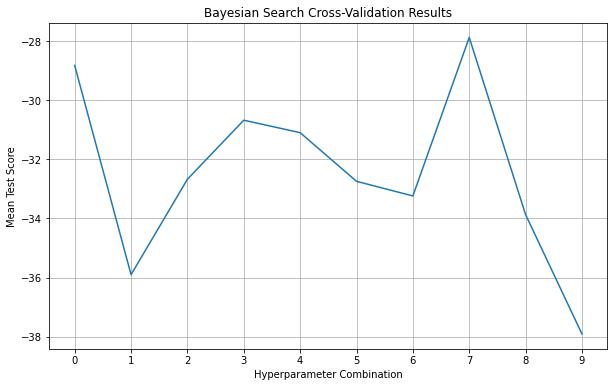

In [119]:
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
firenze_bayes_adj_R, firenze_bayes_rmse, firenze_bayes_mae, firenze_bayes_accuracy = eval_metrics(test_y_firenze, firenze_bayes_pred, firenze_meta_features)

# Print the results
print("Adjusted R-squared:", firenze_bayes_adj_R)
print("RMSE:", firenze_bayes_rmse)
print("Mean Absolute Error:", firenze_bayes_mae)
print("Accuracy:", firenze_bayes_accuracy, "%")

# Get the cv_results_ from the BayesSearchCV
firenze_bayes_results = firenze_bayes_opt.cv_results_

# Convert cv_results to a Pandas DataFrame
firenze_bayes_results_df = pd.DataFrame(firenze_bayes_results)

# Create a line plot to visualize the mean scores for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.plot(firenze_bayes_results_df.index, firenze_bayes_results_df['mean_test_score'])
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Bayesian Search Cross-Validation Results')
plt.xticks(firenze_bayes_results_df.index)
plt.grid(True)
plt.show()

### Genetic Algorithm

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'idx' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Generation 1, RMSE: 3.88, MAE: 0.13, Accuracy: 86.97
Generation 2, RMSE: 3.53, MAE: 0.11, Accuracy: 88.89
Generation 3, RMSE: 3.53, MAE: 0.11, Accuracy: 88.89
Generation 4, RMSE: 3.74, MAE: 0.13, Accuracy: 87.33
Generation 5, RMSE: 3.74, MAE: 0.13, Accuracy: 87.33
Generation 6, RMSE: 3.1, MAE: 0.11, Accuracy: 89.41
Generation 7, RMSE: 3.94, MAE: 0.13, Accuracy: 87.34
Generation 8, RMSE: 4.18, MAE: 0.14, Accuracy: 85.77
Generation 9, RMSE: 4.18, MAE: 0.14, Accuracy: 85.77
Generation 10, RMSE: 4.18, MAE: 0.14, Accuracy: 85.77
Generation 11, RMSE: 3.93, MAE: 0.12, Accuracy: 87.54
Generation 12, RMSE: 4.48, MAE: 0.15, Accuracy: 85.03
Generation 13, RMSE: 3.15, MAE: 0.1, Accuracy: 89.77
Generation 14, RMSE: 3.94, MAE: 0.13, Accuracy: 87.34
Generation 15, RMSE: 2.96, MAE: 0.1, Accuracy: 90.12
Generation 16, RMSE: 2.96, MAE: 0.1, Accuracy: 90.12
Generation 17, RMSE: 2.96, MAE: 0.1, Accuracy: 90.12
Generation 18, RMSE: 3.69, MAE: 0.13, Accuracy: 87.17
Generation 19, RMSE: 3.65, MAE: 0.12, Accu

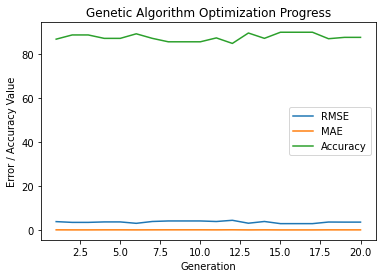

In [120]:
# Usage example for Firenze dataset
best_GAmodel_firenze = optimize_GA(firenze_meta_features, test_y_firenze)

In [121]:
# Use the best model 
best_GAmodel_firenze.fit(firenze_meta_features, test_y_firenze)
firenze_GA_pred = best_GAmodel_firenze.predict(firenze_meta_features)
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
firenze_GA_adj_R, firenze_GA_rmse, firenze_GA_mae, firenze_GA_accuracy = eval_metrics(test_y_firenze, firenze_GA_pred, firenze_meta_features)
# Print the results
print("Adjusted R-squared:", firenze_GA_adj_R)
print("RMSE:", firenze_GA_rmse)
print("Mean Absolute Error:", firenze_GA_mae)
print("Accuracy:", firenze_GA_accuracy, "%")

Adjusted R-squared: 0.89
RMSE: 2.96
Mean Absolute Error: 0.1
Accuracy: 90.12 %


## venezia

In [123]:
# Data Import
venezia_df = pd.read_csv('venezia_df.csv')

nbhd_cleansed_encoder(venezia_df)

# Create a new column called 'distance_from_centre'
# Official location of the city
venezia_latitude = 45.438759
venezia_longitude = 12.327145

# Calculate the distance between each property location and the city centre
venezia_df['distance_from_centre'] = venezia_df.apply(lambda row: haversine_distance(venezia_latitude, venezia_longitude, row['latitude'], row['longitude']), axis=1)
venezia_df['distance_from_centre']

0        0.642115
1        0.279580
2        1.741319
3        0.522261
4        8.171909
          ...    
7983     2.339858
7984     1.515511
7985    24.730861
7986    24.638735
7987    12.490910
Name: distance_from_centre, Length: 7988, dtype: float64

In [124]:
venezia_annual = venezia_df.drop(['latitude', 'longitude'], axis=1)
venezia_annual.head()

,neighborhood_overview,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,room_type,accommodates,bedrooms,beds,amenities,minimum_nights,maximum_nights,has_availability,availability_30,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,license,instant_bookable,reviews_per_month,profitability_by_numOfYears,host_loc2,email,phone,work_email,bathroom_num,bathroom_type,property_type_encoded,neighbourhood_cleansed_encoded,distance_from_centre
0,1,1,3.0,92.0,99.0,0,118.0,3,4,2.0,3.0,19,28,28,1,3,39,295,4,4,0,4.75,0,1,0.83,31.36,0,1,1,0,2.0,-1.0,25,57,0.642115
1,1,1,3.0,92.0,99.0,0,118.0,3,6,2.0,2.0,16,28,28,1,0,0,132,1,0,0,5.00,0,1,0.03,32.32,0,1,1,0,2.0,-1.0,25,59,0.279580
2,1,1,3.0,92.0,99.0,0,118.0,3,4,1.0,1.0,16,28,28,1,5,40,315,2,2,0,4.00,0,1,0.19,31.24,0,1,1,0,1.0,-1.0,25,19,1.741319
3,1,1,3.0,92.0,99.0,0,118.0,3,4,2.0,3.0,19,28,28,1,0,34,268,0,0,0,-1.00,0,1,-1.00,36.98,0,1,1,0,2.0,-1.0,25,15,0.522261
4,0,1,3.0,100.0,100.0,0,2022.0,3,4,1.0,2.0,15,1,28,1,30,90,365,0,0,0,-1.00,0,1,-1.00,75.59,0,1,1,0,1.0,-1.0,25,77,8.171909


In [125]:
# Pop and Insert for devision of x and y
first_column = venezia_annual.pop('profitability_by_numOfYears')
venezia_annual.insert(0, 'profitability_by_numOfYears', first_column)
x_venezia = venezia_annual.iloc[:, 2: ]
y_venezia = venezia_annual.iloc[:, 0: 1]

# train / test split
train_x_venezia, test_x_venezia, train_y_venezia, test_y_venezia = train_test_split(x_venezia, y_venezia, test_size = 0.25, random_state = 123)

# Assuming y is a DataFrame, convert it to a numpy array and then ravel
train_y_venezia = train_y_venezia.values.ravel()
test_y_venezia = test_y_venezia.values.ravel()

print('Training Features Shape:', train_x_venezia.shape)
print('Training Labels Shape:', train_y_venezia.shape)
print('Testing Features Shape:', test_x_venezia.shape)
print('Testing Labels Shape:', test_y_venezia.shape)

Training Features Shape: (5991, 33)
Training Labels Shape: (5991,)
Testing Features Shape: (1997, 33)
Testing Labels Shape: (1997,)


### Random Forest

Best Score: 0.9518182479561398
Adjusted R-squared: 0.63
RMSE: 4.94
Mean Absolute Error: 0.15
Accuracy: 85.13 %


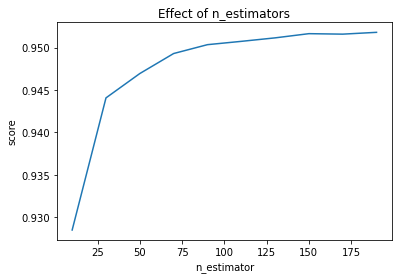

In [126]:
model = RandomForestRegressor() 

# Use the effect_estimators function to get the best model, predictions, and best score
venezia_rf_model, venezia_rf_pred, venezia_rf_score = effect_estimators(train_x_venezia, train_y_venezia, test_x_venezia)
print("Best Score:", venezia_rf_score)

# Call the eval_metrics function and store the results in variables
venezia_rf_adj_R, venezia_rf_rmse, venezia_rf_mae, venezia_rf_accuracy = eval_metrics(test_y_venezia, venezia_rf_pred, train_x_venezia)

# Print the results
print("Adjusted R-squared:", venezia_rf_adj_R)
print("RMSE:", venezia_rf_rmse)
print("Mean Absolute Error:", venezia_rf_mae)
print("Accuracy:", venezia_rf_accuracy, "%")

### Gradient Boosting

Best Score: 0.7163745106244505

Adjusted R-squared: 0.6
RMSE: 5.15
Mean Absolute Error: 0.16
Accuracy: 83.99 %


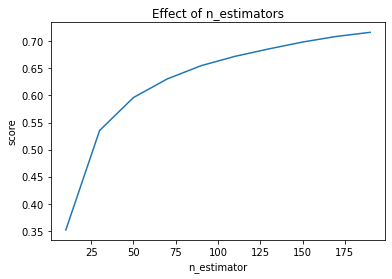

In [127]:
model = GradientBoostingRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
venezia_gb_model, venezia_gb_pred, venezia_gb_score = effect_estimators(train_x_venezia, train_y_venezia, test_x_venezia)
print("Best Score:", venezia_gb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
venezia_gb_adj_R, venezia_gb_rmse, venezia_gb_mae, venezia_gb_accuracy = eval_metrics(test_y_venezia, venezia_gb_pred, train_x_venezia)

# Print the results
print("Adjusted R-squared:", venezia_gb_adj_R)
print("RMSE:", venezia_gb_rmse)
print("Mean Absolute Error:", venezia_gb_mae)
print("Accuracy:", venezia_gb_accuracy, "%")

### Light GBM

Best Score: 0.8995216330501676

Adjusted R-squared: 0.65
RMSE: 4.8
Mean Absolute Error: 0.15
Accuracy: 85.49 %


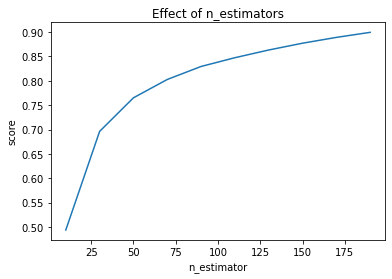

In [128]:
model = lgb.LGBMRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
venezia_lgb_model, venezia_lgb_pred, venezia_lgb_score = effect_estimators(train_x_venezia, train_y_venezia, test_x_venezia)
print("Best Score:", venezia_lgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
venezia_lgb_adj_R, venezia_lgb_rmse, venezia_lgb_mae, venezia_lgb_accuracy = eval_metrics(test_y_venezia, venezia_lgb_pred, train_x_venezia)

# Print the results
print("Adjusted R-squared:", venezia_lgb_adj_R)
print("RMSE:", venezia_lgb_rmse)
print("Mean Absolute Error:", venezia_lgb_mae)
print("Accuracy:", venezia_lgb_accuracy, "%")

### XGBoost

Best Score: 0.9841252032593888

Adjusted R-squared: 0.65
RMSE: 4.81
Mean Absolute Error: 0.14
Accuracy: 85.85 %


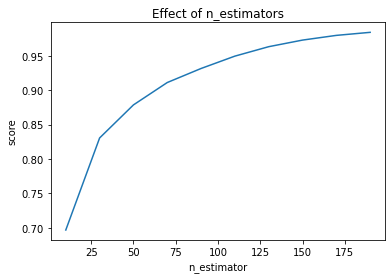

In [129]:
model = xgb.XGBRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
venezia_xgb_model, venezia_xgb_pred, venezia_xgb_score = effect_estimators(train_x_venezia, train_y_venezia, test_x_venezia)
print("Best Score:", venezia_xgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
venezia_xgb_adj_R, venezia_xgb_rmse, venezia_xgb_mae, venezia_xgb_accuracy = eval_metrics(test_y_venezia, venezia_xgb_pred, train_x_venezia)

# Print the results
print("Adjusted R-squared:", venezia_xgb_adj_R)
print("RMSE:", venezia_xgb_rmse)
print("Mean Absolute Error:", venezia_xgb_mae)
print("Accuracy:", venezia_xgb_accuracy, "%")

                    Variable  Importance
0                  host_loc2    0.146792
1  host_total_listings_count    0.105166
2          number_of_reviews    0.068145
3            availability_30    0.061677
4               bathroom_num    0.052677
5                      email    0.046288
6      property_type_encoded    0.042323
7               accommodates    0.035868
8       distance_from_centre    0.029335
9              bathroom_type    0.027655


<AxesSubplot:title={'center':'XGBoost Importance of Venezia'}, xlabel='Importance', ylabel='Variable'>

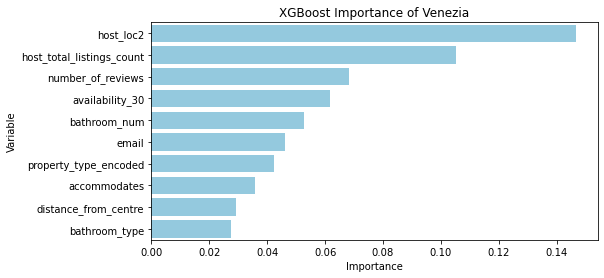

In [130]:
venezia_xgb_10top = important_features(venezia_xgb_model, x_venezia)
print(venezia_xgb_10top)

plt.figure(figsize=(8,4))
plt.title('XGBoost Importance of Venezia')
sns.barplot(y='Variable', x='Importance', data=venezia_xgb_10top, color='skyblue')

### Ensemble Stacking

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Best Score: 0.984544865832309

Adjusted R-squared: 0.98
RMSE: 1.01
Mean Absolute Error: 0.03
Accuracy: 96.98 %


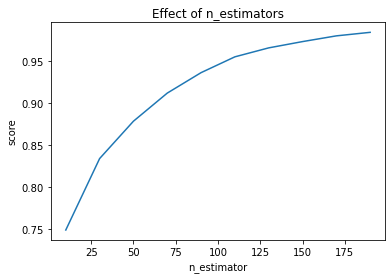

In [131]:
model = xgb.XGBRegressor()   
# Create a new feature matrix with base learners' predictions as meta-features
venezia_meta_features = np.column_stack((venezia_rf_pred, venezia_gb_pred, venezia_lgb_pred))

# Use the effect_estimators function to get the best model, predictions, and best score
venezia_stack_model, venezia_stack_pred, venezia_stack_score = effect_estimators(venezia_meta_features, test_y_venezia, venezia_meta_features)

print(venezia_stack_model)
print()
print("Best Score:", venezia_stack_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
venezia_stack_adj_R, venezia_stack_rmse, venezia_stack_mae, venezia_stack_accuracy = eval_metrics(test_y_venezia, venezia_stack_pred, venezia_meta_features)

# Print the results
print("Adjusted R-squared:", venezia_stack_adj_R)
print("RMSE:", venezia_stack_rmse)
print("Mean Absolute Error:", venezia_stack_mae)
print("Accuracy:", venezia_stack_accuracy, "%")

### Bayesian optimisation

In [132]:
# Meta Learner
venezia_meta_learner = xgb.XGBRegressor(n_estimators=100, random_state=123)

# Perform Bayesian Search for the meta-learner
venezia_bayes_opt = BayesSearchCV(venezia_meta_learner, bayes_search, n_iter=10, cv=10, 
                         scoring="neg_mean_squared_error", verbose=4, random_state=123) 

# Fit the optimized meta-learner on the meta-features
venezia_bayes_opt.fit(venezia_meta_features, test_y_venezia)

# Make predictions using the meta-learner on the test data
venezia_bayes_pred = venezia_bayes_opt.predict(venezia_meta_features)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-23.752 total time=   0.9s
[CV 2/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-31.497 total time=   0.9s
[CV 3/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-28.103 total time=   0.9s
[CV 4/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-23.530 total time=   0.9s
[CV 5/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-32.176 total time=   0.9s
[CV 6/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-35.547 total time=   0.9s
[CV 7/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimator

[CV 8/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-35.424 total time=   2.5s
[CV 9/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-30.084 total time=   2.9s
[CV 10/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-30.855 total time=   2.7s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-30.463 total time=   2.0s
[CV 2/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-35.413 total time=   1.8s
[CV 3/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-30.083 total time=   1.9s
[CV 4/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183

In [133]:
# Access the best results
print("Best MSE Score:", -venezia_bayes_opt.best_score_)
print("Best Parameters:", venezia_bayes_opt.best_params_)

Best MSE Score: 27.87022677134259
Best Parameters: OrderedDict([('gamma', 0.7703399241440627), ('learning_rate', 0.19204784774815406), ('max_depth', 2), ('n_estimators', 764)])


Adjusted R-squared: 0.87
RMSE: 3.0
Mean Absolute Error: 0.09
Accuracy: 90.66 %


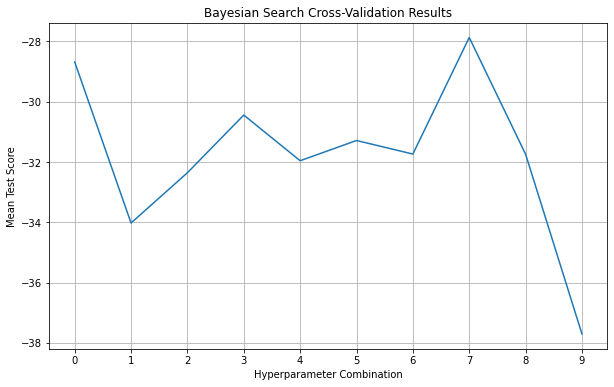

In [134]:
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
venezia_bayes_adj_R, venezia_bayes_rmse, venezia_bayes_mae, venezia_bayes_accuracy = eval_metrics(test_y_venezia, venezia_bayes_pred, venezia_meta_features)

# Print the results
print("Adjusted R-squared:", venezia_bayes_adj_R)
print("RMSE:", venezia_bayes_rmse)
print("Mean Absolute Error:", venezia_bayes_mae)
print("Accuracy:", venezia_bayes_accuracy, "%")

# Get the cv_results_ from the BayesSearchCV
venezia_bayes_results = venezia_bayes_opt.cv_results_

# Convert cv_results to a Pandas DataFrame
venezia_bayes_results_df = pd.DataFrame(venezia_bayes_results)

# Create a line plot to visualize the mean scores for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.plot(venezia_bayes_results_df.index, venezia_bayes_results_df['mean_test_score'])
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Bayesian Search Cross-Validation Results')
plt.xticks(venezia_bayes_results_df.index)
plt.grid(True)
plt.show()

### Genetic Algorithm

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'idx' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Generation 1, RMSE: 8.46, MAE: 0.24, Accuracy: 76.03
Generation 2, RMSE: 8.17, MAE: 0.26, Accuracy: 73.97
Generation 3, RMSE: 8.17, MAE: 0.26, Accuracy: 73.97
Generation 4, RMSE: 8.16, MAE: 0.26, Accuracy: 73.67
Generation 5, RMSE: 8.16, MAE: 0.26, Accuracy: 73.66
Generation 6, RMSE: 5.44, MAE: 0.17, Accuracy: 83.09
Generation 7, RMSE: 8.16, MAE: 0.26, Accuracy: 73.66
Generation 8, RMSE: 3.51, MAE: 0.1, Accuracy: 89.84
Generation 9, RMSE: 3.51, MAE: 0.1, Accuracy: 89.84
Generation 10, RMSE: 3.51, MAE: 0.1, Accuracy: 89.84
Generation 11, RMSE: 3.51, MAE: 0.1, Accuracy: 89.84
Generation 12, RMSE: 3.51, MAE: 0.1, Accuracy: 89.84
Generation 13, RMSE: 3.51, MAE: 0.1, Accuracy: 89.84
Generation 14, RMSE: 3.79, MAE: 0.11, Accuracy: 88.67
Generation 15, RMSE: 2.39, MAE: 0.07, Accuracy: 93.03
Generation 16, RMSE: 3.02, MAE: 0.09, Accuracy: 91.04
Generation 17, RMSE: 3.51, MAE: 0.11, Accuracy: 89.41
Generation 18, RMSE: 3.22, MAE: 0.1, Accuracy: 90.35
Generation 19, RMSE: 3.2, MAE: 0.09, Accurac

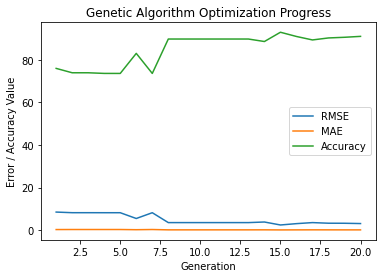

In [135]:
# Usage example for Venezia dataset
best_GAmodel_venezia = optimize_GA(venezia_meta_features, test_y_venezia)

In [136]:
# Use the best model 
best_GAmodel_venezia.fit(venezia_meta_features, test_y_venezia)
venezia_GA_pred = best_GAmodel_venezia.predict(venezia_meta_features)
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
venezia_GA_adj_R, venezia_GA_rmse, venezia_GA_mae, venezia_GA_accuracy = eval_metrics(test_y_venezia, venezia_GA_pred, venezia_meta_features)
# Print the results
print("Adjusted R-squared:", venezia_GA_adj_R)
print("RMSE:", venezia_GA_rmse)
print("Mean Absolute Error:", venezia_GA_mae)
print("Accuracy:", venezia_GA_accuracy, "%")

Adjusted R-squared: 0.91
RMSE: 2.39
Mean Absolute Error: 0.07
Accuracy: 93.03 %


## napoli

In [138]:
# Data Import
napoli_df = pd.read_csv('napoli_df.csv')

nbhd_cleansed_encoder(napoli_df)

# Create a new column called 'distance_from_centre'
# Official location of the city
napoli_latitude = 40.853294
napoli_longitude = 14.305573

# Calculate the distance between each property location and the city centre
napoli_df['distance_from_centre'] = napoli_df.apply(lambda row: haversine_distance(napoli_latitude, napoli_longitude, row['latitude'], row['longitude']), axis=1)
napoli_df['distance_from_centre']

0        1.799974
1        5.104403
2        5.793873
3        5.175075
4        3.933721
          ...    
7502    13.337213
7503     9.805995
7504    11.404952
7505     6.999798
7506    12.585494
Name: distance_from_centre, Length: 7507, dtype: float64

In [139]:
napoli_annual = napoli_df.drop(['latitude', 'longitude'], axis=1)
napoli_annual.head()

,neighborhood_overview,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,room_type,accommodates,bedrooms,beds,amenities,minimum_nights,maximum_nights,has_availability,availability_30,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,license,instant_bookable,reviews_per_month,profitability_by_numOfYears,host_loc2,email,phone,work_email,bathroom_num,bathroom_type,property_type_encoded,neighbourhood_cleansed_encoded,distance_from_centre
0,1,1,3.0,100.0,90.0,0,383.0,3,4,1.0,3.0,17,1,1125,1,29,89,364,4,1,0,3.50,0,0,0.10,36.04,0,1,1,0,1.0,-1.0,25,19,1.799974
1,1,1,3.0,98.0,99.0,0,1469.0,3,4,2.0,2.0,23,1,1125,1,4,45,63,88,16,1,4.43,0,1,1.19,24.79,1,1,1,1,2.0,-1.0,25,1,5.104403
2,1,1,3.0,98.0,99.0,0,1469.0,3,10,3.0,5.0,27,1,1125,1,13,39,57,42,17,0,4.19,0,1,0.59,31.16,1,1,1,1,3.0,-1.0,25,18,5.793873
3,1,1,3.0,98.0,99.0,0,1469.0,3,4,2.0,2.0,32,1,1125,1,16,71,89,27,14,3,4.15,0,1,0.52,25.58,1,1,1,1,2.0,-1.0,25,1,5.175075
4,1,1,3.0,98.0,99.0,0,1469.0,3,9,4.0,5.0,24,1,1125,1,7,34,46,48,18,0,4.50,0,1,0.88,28.85,1,1,1,1,2.0,-1.0,25,10,3.933721


In [140]:
# Pop and Insert for devision of x and y
first_column = napoli_annual.pop('profitability_by_numOfYears')
napoli_annual.insert(0, 'profitability_by_numOfYears', first_column)
x_napoli = napoli_annual.iloc[:, 2: ]
y_napoli = napoli_annual.iloc[:, 0: 1]

# train / test split
train_x_napoli, test_x_napoli, train_y_napoli, test_y_napoli = train_test_split(x_napoli, y_napoli, test_size = 0.25, random_state = 123)

# Assuming y is a DataFrame, convert it to a numpy array and then ravel
train_y_napoli = train_y_napoli.values.ravel()
test_y_napoli = test_y_napoli.values.ravel()

print('Training Features Shape:', train_x_napoli.shape)
print('Training Labels Shape:', train_y_napoli.shape)
print('Testing Features Shape:', test_x_napoli.shape)
print('Testing Labels Shape:', test_y_napoli.shape)

Training Features Shape: (5630, 33)
Training Labels Shape: (5630,)
Testing Features Shape: (1877, 33)
Testing Labels Shape: (1877,)


### Random Forest

Best Score: 0.93430883528766
Adjusted R-squared: 0.5
RMSE: 5.61
Mean Absolute Error: 0.2
Accuracy: 80.03 %


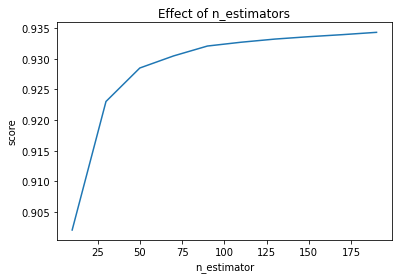

In [141]:
model = RandomForestRegressor() 

# Use the effect_estimators function to get the best model, predictions, and best score
napoli_rf_model, napoli_rf_pred, napoli_rf_score = effect_estimators(train_x_napoli, train_y_napoli, test_x_napoli)
print("Best Score:", napoli_rf_score)

# Call the eval_metrics function and store the results in variables
napoli_rf_adj_R, napoli_rf_rmse, napoli_rf_mae, napoli_rf_accuracy = eval_metrics(test_y_napoli, napoli_rf_pred, train_x_napoli)

# Print the results
print("Adjusted R-squared:", napoli_rf_adj_R)
print("RMSE:", napoli_rf_rmse)
print("Mean Absolute Error:", napoli_rf_mae)
print("Accuracy:", napoli_rf_accuracy, "%")

### Gradient Boosting

Best Score: 0.6040123772058652

Adjusted R-squared: 0.49
RMSE: 5.71
Mean Absolute Error: 0.2
Accuracy: 79.63 %


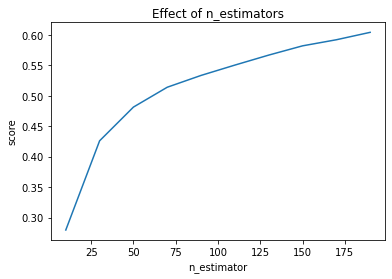

In [142]:
model = GradientBoostingRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
napoli_gb_model, napoli_gb_pred, napoli_gb_score = effect_estimators(train_x_napoli, train_y_napoli, test_x_napoli)
print("Best Score:", napoli_gb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
napoli_gb_adj_R, napoli_gb_rmse, napoli_gb_mae, napoli_gb_accuracy = eval_metrics(test_y_napoli, napoli_gb_pred, train_x_napoli)

# Print the results
print("Adjusted R-squared:", napoli_gb_adj_R)
print("RMSE:", napoli_gb_rmse)
print("Mean Absolute Error:", napoli_gb_mae)
print("Accuracy:", napoli_gb_accuracy, "%")

### Light GBM

Best Score: 0.8616944516318976

Adjusted R-squared: 0.53
RMSE: 5.47
Mean Absolute Error: 0.19
Accuracy: 80.7 %


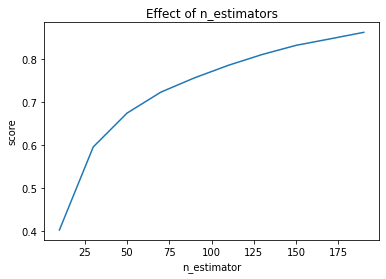

In [143]:
model = lgb.LGBMRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
napoli_lgb_model, napoli_lgb_pred, napoli_lgb_score = effect_estimators(train_x_napoli, train_y_napoli, test_x_napoli)
print("Best Score:", napoli_lgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
napoli_lgb_adj_R, napoli_lgb_rmse, napoli_lgb_mae, napoli_lgb_accuracy = eval_metrics(test_y_napoli, napoli_lgb_pred, train_x_napoli)

# Print the results
print("Adjusted R-squared:", napoli_lgb_adj_R)
print("RMSE:", napoli_lgb_rmse)
print("Mean Absolute Error:", napoli_lgb_mae)
print("Accuracy:", napoli_lgb_accuracy, "%")

### XGBoost

Best Score: 0.9809384354542744

Adjusted R-squared: 0.5
RMSE: 5.62
Mean Absolute Error: 0.19
Accuracy: 80.78 %


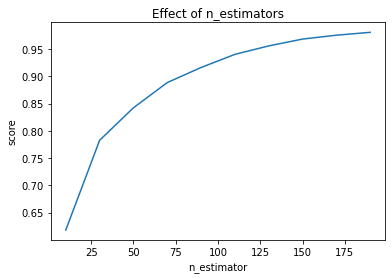

In [144]:
model = xgb.XGBRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
napoli_xgb_model, napoli_xgb_pred, napoli_xgb_score = effect_estimators(train_x_napoli, train_y_napoli, test_x_napoli)
print("Best Score:", napoli_xgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
napoli_xgb_adj_R, napoli_xgb_rmse, napoli_xgb_mae, napoli_xgb_accuracy = eval_metrics(test_y_napoli, napoli_xgb_pred, train_x_napoli)

# Print the results
print("Adjusted R-squared:", napoli_xgb_adj_R)
print("RMSE:", napoli_xgb_rmse)
print("Mean Absolute Error:", napoli_xgb_mae)
print("Accuracy:", napoli_xgb_accuracy, "%")

                    Variable  Importance
0                  host_loc2    0.320328
1           has_availability    0.067017
2                   bedrooms    0.059179
3          number_of_reviews    0.036950
4                  room_type    0.035161
5               bathroom_num    0.033195
6               accommodates    0.028329
7  host_total_listings_count    0.028107
8                      email    0.027241
9      property_type_encoded    0.025799


<AxesSubplot:title={'center':'XGBoost Importance of Napoli'}, xlabel='Importance', ylabel='Variable'>

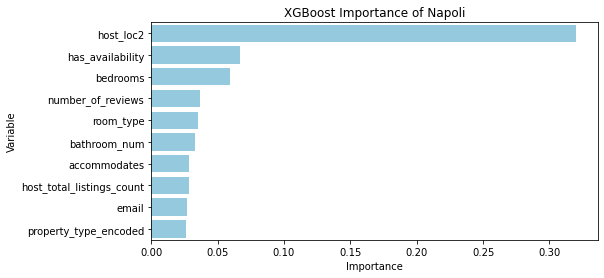

In [145]:
napoli_xgb_10top = important_features(napoli_xgb_model, x_napoli)
print(napoli_xgb_10top)

plt.figure(figsize=(8,4))
plt.title('XGBoost Importance of Napoli')
sns.barplot(y='Variable', x='Importance', data=napoli_xgb_10top, color='skyblue')

### Ensemble Stacking

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Best Score: 0.9843840402678283

Adjusted R-squared: 0.98
RMSE: 1.0
Mean Absolute Error: 0.04
Accuracy: 96.44 %


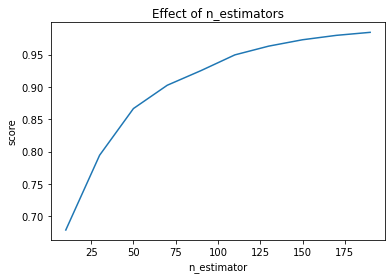

In [146]:
model = xgb.XGBRegressor()   
# Create a new feature matrix with base learners' predictions as meta-features
napoli_meta_features = np.column_stack((napoli_rf_pred, napoli_gb_pred, napoli_lgb_pred))

# Use the effect_estimators function to get the best model, predictions, and best score
napoli_stack_model, napoli_stack_pred, napoli_stack_score = effect_estimators(napoli_meta_features, test_y_napoli, napoli_meta_features)

print(napoli_stack_model)
print()
print("Best Score:", napoli_stack_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
napoli_stack_adj_R, napoli_stack_rmse, napoli_stack_mae, napoli_stack_accuracy = eval_metrics(test_y_napoli, napoli_stack_pred, napoli_meta_features)

# Print the results
print("Adjusted R-squared:", napoli_stack_adj_R)
print("RMSE:", napoli_stack_rmse)
print("Mean Absolute Error:", napoli_stack_mae)
print("Accuracy:", napoli_stack_accuracy, "%")

### Bayesian optimisation

In [147]:
# Meta Learner
napoli_meta_learner = xgb.XGBRegressor(n_estimators=100, random_state=123)

# Perform Bayesian Search for the meta-learner
napoli_bayes_opt = BayesSearchCV(napoli_meta_learner, bayes_search, n_iter=10, cv=10, 
                         scoring="neg_mean_squared_error", verbose=4, random_state=123) 

# Fit the optimized meta-learner on the meta-features
napoli_bayes_opt.fit(napoli_meta_features, test_y_napoli)

# Make predictions using the meta-learner on the test data
napoli_bayes_pred = napoli_bayes_opt.predict(napoli_meta_features)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-36.608 total time=   0.9s
[CV 2/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-36.411 total time=   0.9s
[CV 3/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-41.379 total time=   0.9s
[CV 4/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-41.400 total time=   0.9s
[CV 5/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-41.522 total time=   0.9s
[CV 6/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-41.206 total time=   0.9s
[CV 7/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimator

[CV 8/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-47.710 total time=   2.5s
[CV 9/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-39.005 total time=   2.5s
[CV 10/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-41.139 total time=   2.5s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-41.477 total time=   1.7s
[CV 2/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-40.012 total time=   1.7s
[CV 3/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-44.912 total time=   1.7s
[CV 4/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183

In [148]:
# Access the best results
print("Best MSE Score:", -napoli_bayes_opt.best_score_)
print("Best Parameters:", napoli_bayes_opt.best_params_)

Best MSE Score: 38.01020165335936
Best Parameters: OrderedDict([('gamma', 0.7703399241440627), ('learning_rate', 0.19204784774815406), ('max_depth', 2), ('n_estimators', 764)])


Adjusted R-squared: 0.83
RMSE: 3.34
Mean Absolute Error: 0.12
Accuracy: 87.79 %


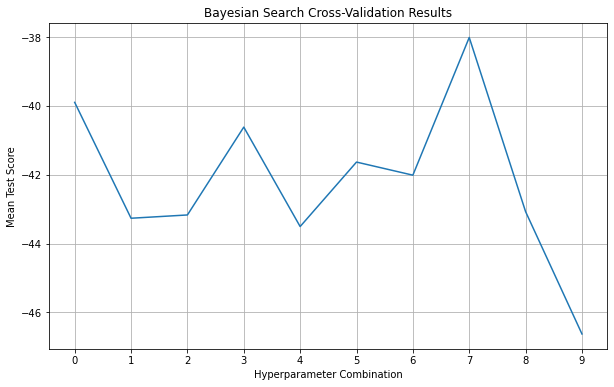

In [149]:
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
napoli_bayes_adj_R, napoli_bayes_rmse, napoli_bayes_mae, napoli_bayes_accuracy = eval_metrics(test_y_napoli, napoli_bayes_pred, napoli_meta_features)

# Print the results
print("Adjusted R-squared:", napoli_bayes_adj_R)
print("RMSE:", napoli_bayes_rmse)
print("Mean Absolute Error:", napoli_bayes_mae)
print("Accuracy:", napoli_bayes_accuracy, "%")

# Get the cv_results_ from the BayesSearchCV
napoli_bayes_results = napoli_bayes_opt.cv_results_

# Convert cv_results to a Pandas DataFrame
napoli_bayes_results_df = pd.DataFrame(napoli_bayes_results)

# Create a line plot to visualize the mean scores for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.plot(napoli_bayes_results_df.index, napoli_bayes_results_df['mean_test_score'])
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Bayesian Search Cross-Validation Results')
plt.xticks(napoli_bayes_results_df.index)
plt.grid(True)
plt.show()

### Genetic Algorithm

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'idx' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Generation 1, RMSE: 8.04, MAE: 0.3, Accuracy: 69.98
Generation 2, RMSE: 5.61, MAE: 0.19, Accuracy: 80.86
Generation 3, RMSE: 2.34, MAE: 0.08, Accuracy: 91.71
Generation 4, RMSE: 2.34, MAE: 0.08, Accuracy: 91.71
Generation 5, RMSE: 2.34, MAE: 0.08, Accuracy: 91.71
Generation 6, RMSE: 5.25, MAE: 0.16, Accuracy: 83.89
Generation 7, RMSE: 4.14, MAE: 0.15, Accuracy: 85.43
Generation 8, RMSE: 4.9, MAE: 0.17, Accuracy: 82.54
Generation 9, RMSE: 3.43, MAE: 0.12, Accuracy: 87.74
Generation 10, RMSE: 3.43, MAE: 0.12, Accuracy: 87.74
Generation 11, RMSE: 4.9, MAE: 0.17, Accuracy: 82.54
Generation 12, RMSE: 4.98, MAE: 0.18, Accuracy: 82.49
Generation 13, RMSE: 4.29, MAE: 0.15, Accuracy: 84.98
Generation 14, RMSE: 4.53, MAE: 0.16, Accuracy: 84.32
Generation 15, RMSE: 4.53, MAE: 0.16, Accuracy: 84.32
Generation 16, RMSE: 3.43, MAE: 0.12, Accuracy: 87.74
Generation 17, RMSE: 3.33, MAE: 0.11, Accuracy: 88.78
Generation 18, RMSE: 3.33, MAE: 0.11, Accuracy: 88.78
Generation 19, RMSE: 3.33, MAE: 0.11, Ac

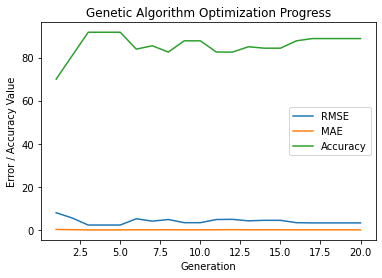

In [150]:
# Usage example for Napoli dataset
best_GAmodel_napoli = optimize_GA(napoli_meta_features, test_y_napoli)

In [151]:
# Use the best model 
best_GAmodel_napoli.fit(napoli_meta_features, test_y_napoli)
napoli_GA_pred = best_GAmodel_napoli.predict(napoli_meta_features)
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
napoli_GA_adj_R, napoli_GA_rmse, napoli_GA_mae, napoli_GA_accuracy = eval_metrics(test_y_napoli, napoli_GA_pred, napoli_meta_features)
# Print the results
print("Adjusted R-squared:", napoli_GA_adj_R)
print("RMSE:", napoli_GA_rmse)
print("Mean Absolute Error:", napoli_GA_mae)
print("Accuracy:", napoli_GA_accuracy, "%")

Adjusted R-squared: 0.91
RMSE: 2.34
Mean Absolute Error: 0.08
Accuracy: 91.71 %


## bologna

In [153]:
# Data Import
bologna_df = pd.read_csv('bologna_df.csv')

nbhd_cleansed_encoder(bologna_df)

# Create a new column called 'distance_from_centre'
# Official location of the city
bologna_latitude = 44.498955
bologna_longitude = 11.327591

# Calculate the distance between each property location and the city centre
bologna_df['distance_from_centre'] = bologna_df.apply(lambda row: haversine_distance(bologna_latitude, bologna_longitude, row['latitude'], row['longitude']), axis=1)
bologna_df['distance_from_centre']

0       7.843632
1       2.760191
2       2.229040
3       1.006429
4       0.938353
          ...   
3890    2.549894
3891    1.132194
3892    1.894020
3893    3.683252
3894    4.105658
Name: distance_from_centre, Length: 3895, dtype: float64

In [154]:
bologna_annual = bologna_df.drop(['latitude', 'longitude'], axis=1)
bologna_annual.head()

,neighborhood_overview,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,room_type,accommodates,bedrooms,beds,amenities,minimum_nights,maximum_nights,has_availability,availability_30,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,license,instant_bookable,reviews_per_month,profitability_by_numOfYears,host_loc2,email,phone,work_email,bathroom_num,bathroom_type,property_type_encoded,neighbourhood_cleansed_encoded,distance_from_centre
0,0,1,3.0,100.0,100.0,0,2025.0,3,5,2.0,3.0,14,1,28,1,30,90,365,6,0,0,4.50,0,1,0.23,75.55,0,1,1,0,1.0,-1.0,25,5,7.843632
1,1,1,3.0,96.0,99.0,0,36.0,3,2,1.0,1.0,35,1,1125,1,9,69,100,3,3,0,5.00,0,1,1.84,25.63,0,0,1,0,1.0,-1.0,23,1,2.760191
2,0,1,2.0,100.0,100.0,1,7.0,3,2,1.0,1.0,26,3,360,1,0,1,235,195,16,0,4.66,0,1,1.34,20.86,1,1,1,0,1.0,-1.0,25,4,2.229040
3,1,1,1.0,92.0,86.0,1,9.0,1,2,1.0,1.0,33,1,730,1,0,35,296,331,51,3,4.67,0,0,2.27,17.26,1,1,1,0,1.0,0.0,72,2,1.006429
4,1,1,1.0,92.0,86.0,1,9.0,1,1,1.0,1.0,34,1,1125,1,2,41,296,343,64,7,4.80,0,0,3.12,16.80,1,1,1,0,1.0,0.0,72,2,0.938353


In [155]:
# Pop and Insert for devision of x and y
first_column = bologna_annual.pop('profitability_by_numOfYears')
bologna_annual.insert(0, 'profitability_by_numOfYears', first_column)
x_bologna = bologna_annual.iloc[:, 2: ]
y_bologna = bologna_annual.iloc[:, 0: 1]

# train / test split
train_x_bologna, test_x_bologna, train_y_bologna, test_y_bologna = train_test_split(x_bologna, y_bologna, test_size = 0.25, random_state = 123)

# Assuming y is a DataFrame, convert it to a numpy array and then ravel
train_y_bologna = train_y_bologna.values.ravel()
test_y_bologna = test_y_bologna.values.ravel()

print('Training Features Shape:', train_x_bologna.shape)
print('Training Labels Shape:', train_y_bologna.shape)
print('Testing Features Shape:', test_x_bologna.shape)
print('Testing Labels Shape:', test_y_bologna.shape)

Training Features Shape: (2921, 33)
Training Labels Shape: (2921,)
Testing Features Shape: (974, 33)
Testing Labels Shape: (974,)


### Random Forest

Best Score: 0.9385250032869918
Adjusted R-squared: 0.5
RMSE: 5.51
Mean Absolute Error: 0.18
Accuracy: 82.3 %


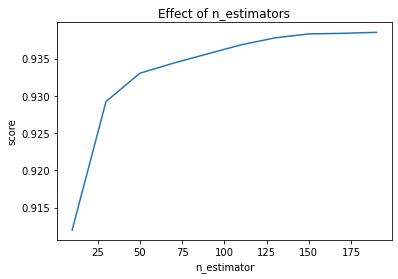

In [156]:
model = RandomForestRegressor() 

# Use the effect_estimators function to get the best model, predictions, and best score
bologna_rf_model, bologna_rf_pred, bologna_rf_score = effect_estimators(train_x_bologna, train_y_bologna, test_x_bologna)
print("Best Score:", bologna_rf_score)

# Call the eval_metrics function and store the results in variables
bologna_rf_adj_R, bologna_rf_rmse, bologna_rf_mae, bologna_rf_accuracy = eval_metrics(test_y_bologna, bologna_rf_pred, train_x_bologna)

# Print the results
print("Adjusted R-squared:", bologna_rf_adj_R)
print("RMSE:", bologna_rf_rmse)
print("Mean Absolute Error:", bologna_rf_mae)
print("Accuracy:", bologna_rf_accuracy, "%")

### Gradient Boosting

Best Score: 0.6986202098288288

Adjusted R-squared: 0.48
RMSE: 5.59
Mean Absolute Error: 0.18
Accuracy: 81.57 %


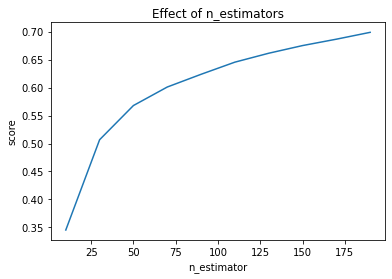

In [157]:
model = GradientBoostingRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
bologna_gb_model, bologna_gb_pred, bologna_gb_score = effect_estimators(train_x_bologna, train_y_bologna, test_x_bologna)
print("Best Score:", bologna_gb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
bologna_gb_adj_R, bologna_gb_rmse, bologna_gb_mae, bologna_gb_accuracy = eval_metrics(test_y_bologna, bologna_gb_pred, train_x_bologna)

# Print the results
print("Adjusted R-squared:", bologna_gb_adj_R)
print("RMSE:", bologna_gb_rmse)
print("Mean Absolute Error:", bologna_gb_mae)
print("Accuracy:", bologna_gb_accuracy, "%")

### Light GBM

Best Score: 0.9375273247093854

Adjusted R-squared: 0.52
RMSE: 5.4
Mean Absolute Error: 0.17
Accuracy: 82.76 %


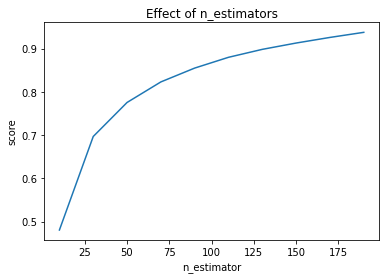

In [158]:
model = lgb.LGBMRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
bologna_lgb_model, bologna_lgb_pred, bologna_lgb_score = effect_estimators(train_x_bologna, train_y_bologna, test_x_bologna)
print("Best Score:", bologna_lgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
bologna_lgb_adj_R, bologna_lgb_rmse, bologna_lgb_mae, bologna_lgb_accuracy = eval_metrics(test_y_bologna, bologna_lgb_pred, train_x_bologna)

# Print the results
print("Adjusted R-squared:", bologna_lgb_adj_R)
print("RMSE:", bologna_lgb_rmse)
print("Mean Absolute Error:", bologna_lgb_mae)
print("Accuracy:", bologna_lgb_accuracy, "%")

### XGBoost

Best Score: 0.9976703754029048

Adjusted R-squared: 0.46
RMSE: 5.72
Mean Absolute Error: 0.18
Accuracy: 81.96 %


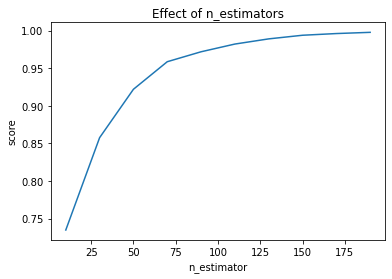

In [159]:
model = xgb.XGBRegressor()   

# Use the effect_estimators function to get the best model, predictions, and best score
bologna_xgb_model, bologna_xgb_pred, bologna_xgb_score = effect_estimators(train_x_bologna, train_y_bologna, test_x_bologna)
print("Best Score:", bologna_xgb_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
bologna_xgb_adj_R, bologna_xgb_rmse, bologna_xgb_mae, bologna_xgb_accuracy = eval_metrics(test_y_bologna, bologna_xgb_pred, train_x_bologna)

# Print the results
print("Adjusted R-squared:", bologna_xgb_adj_R)
print("RMSE:", bologna_xgb_rmse)
print("Mean Absolute Error:", bologna_xgb_mae)
print("Accuracy:", bologna_xgb_accuracy, "%")

                    Variable  Importance
0                  host_loc2    0.441412
1  host_total_listings_count    0.075271
2      property_type_encoded    0.042124
3               accommodates    0.037510
4               bathroom_num    0.031475
5           instant_bookable    0.029153
6          number_of_reviews    0.028114
7                   bedrooms    0.021621
8            availability_30    0.019802
9                  room_type    0.019164


<AxesSubplot:title={'center':'XGBoost Importance of Bologna'}, xlabel='Importance', ylabel='Variable'>

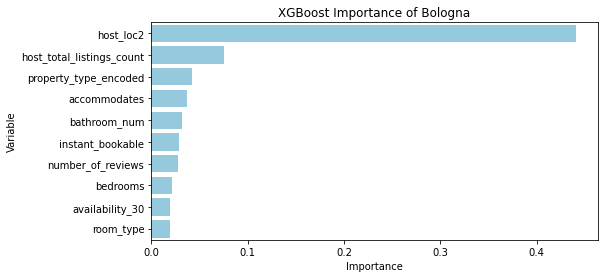

In [160]:
bologna_xgb_10top = important_features(bologna_xgb_model, x_bologna)
print(bologna_xgb_10top)

plt.figure(figsize=(8,4))
plt.title('XGBoost Importance of Bologna')
sns.barplot(y='Variable', x='Importance', data=bologna_xgb_10top, color='skyblue')

### Ensemble Stacking

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Best Score: 0.99816306496533

Adjusted R-squared: 1.0
RMSE: 0.34
Mean Absolute Error: 0.01
Accuracy: 98.84 %


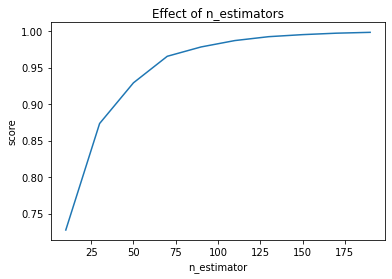

In [161]:
model = xgb.XGBRegressor()   
# Create a new feature matrix with base learners' predictions as meta-features
bologna_meta_features = np.column_stack((bologna_rf_pred, bologna_gb_pred, bologna_lgb_pred))

# Use the effect_estimators function to get the best model, predictions, and best score
bologna_stack_model, bologna_stack_pred, bologna_stack_score = effect_estimators(bologna_meta_features, test_y_bologna, bologna_meta_features)

print(bologna_stack_model)
print()
print("Best Score:", bologna_stack_score)
print()

# Evaluation Tools
# Call the eval_metrics function and store the results in variables
bologna_stack_adj_R, bologna_stack_rmse, bologna_stack_mae, bologna_stack_accuracy = eval_metrics(test_y_bologna, bologna_stack_pred, bologna_meta_features)

# Print the results
print("Adjusted R-squared:", bologna_stack_adj_R)
print("RMSE:", bologna_stack_rmse)
print("Mean Absolute Error:", bologna_stack_mae)
print("Accuracy:", bologna_stack_accuracy, "%")

### Bayesian optimisation

In [162]:
# Meta Learner
bologna_meta_learner = xgb.XGBRegressor(n_estimators=100, random_state=123)

# Perform Bayesian Search for the meta-learner
bologna_bayes_opt = BayesSearchCV(bologna_meta_learner, bayes_search, n_iter=10, cv=10, 
                         scoring="neg_mean_squared_error", verbose=4, random_state=123) 

# Fit the optimized meta-learner on the meta-features
bologna_bayes_opt.fit(bologna_meta_features, test_y_bologna)

# Make predictions using the meta-learner on the test data
bologna_bayes_pred = bologna_bayes_opt.predict(bologna_meta_features)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-27.758 total time=   0.7s
[CV 2/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-36.438 total time=   0.7s
[CV 3/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-43.362 total time=   0.7s
[CV 4/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-53.651 total time=   0.8s
[CV 5/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-43.705 total time=   0.7s
[CV 6/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimators=517;, score=-40.825 total time=   0.7s
[CV 7/10] END gamma=0.8601068320616704, learning_rate=0.37394762512094704, max_depth=2, n_estimator

[CV 8/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-37.046 total time=   1.5s
[CV 9/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-33.189 total time=   1.7s
[CV 10/10] END gamma=0.418203248656915, learning_rate=0.588082369809232, max_depth=11, n_estimators=365;, score=-34.072 total time=   1.7s
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-32.357 total time=   1.1s
[CV 2/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-33.657 total time=   1.4s
[CV 3/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183;, score=-42.764 total time=   1.1s
[CV 4/10] END gamma=0.7604552944997698, learning_rate=0.6115645422189172, max_depth=15, n_estimators=183

In [163]:
# Access the best results
print("Best MSE Score:", -bologna_bayes_opt.best_score_)
print("Best Parameters:", bologna_bayes_opt.best_params_)

Best MSE Score: 38.23506177049619
Best Parameters: OrderedDict([('gamma', 0.7703399241440627), ('learning_rate', 0.19204784774815406), ('max_depth', 2), ('n_estimators', 764)])


Adjusted R-squared: 0.92
RMSE: 2.27
Mean Absolute Error: 0.08
Accuracy: 91.73 %


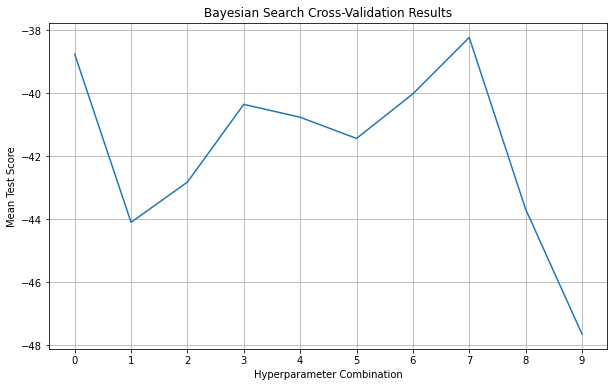

In [164]:
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
bologna_bayes_adj_R, bologna_bayes_rmse, bologna_bayes_mae, bologna_bayes_accuracy = eval_metrics(test_y_bologna, bologna_bayes_pred, bologna_meta_features)

# Print the results
print("Adjusted R-squared:", bologna_bayes_adj_R)
print("RMSE:", bologna_bayes_rmse)
print("Mean Absolute Error:", bologna_bayes_mae)
print("Accuracy:", bologna_bayes_accuracy, "%")

# Get the cv_results_ from the BayesSearchCV
bologna_bayes_results = bologna_bayes_opt.cv_results_

# Convert cv_results to a Pandas DataFrame
bologna_bayes_results_df = pd.DataFrame(bologna_bayes_results)

# Create a line plot to visualize the mean scores for different hyperparameter combinations
plt.figure(figsize=(10, 6))
plt.plot(bologna_bayes_results_df.index, bologna_bayes_results_df['mean_test_score'])
plt.xlabel('Hyperparameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Bayesian Search Cross-Validation Results')
plt.xticks(bologna_bayes_results_df.index)
plt.grid(True)
plt.show()

### Genetic Algorithm

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:188: RuntimeWarning: A class named 'idx' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Generation 1, RMSE: 5.26, MAE: 0.18, Accuracy: 82.37
Generation 2, RMSE: 5.26, MAE: 0.18, Accuracy: 82.37
Generation 3, RMSE: 5.26, MAE: 0.18, Accuracy: 82.37
Generation 4, RMSE: 5.26, MAE: 0.18, Accuracy: 82.37
Generation 5, RMSE: 4.49, MAE: 0.13, Accuracy: 87.06
Generation 6, RMSE: 4.49, MAE: 0.13, Accuracy: 87.06
Generation 7, RMSE: 2.59, MAE: 0.09, Accuracy: 91.43
Generation 8, RMSE: 2.59, MAE: 0.09, Accuracy: 91.43
Generation 9, RMSE: 2.77, MAE: 0.09, Accuracy: 91.39
Generation 10, RMSE: 3.33, MAE: 0.11, Accuracy: 88.77
Generation 11, RMSE: 3.33, MAE: 0.11, Accuracy: 88.77
Generation 12, RMSE: 3.78, MAE: 0.12, Accuracy: 87.82
Generation 13, RMSE: 3.72, MAE: 0.12, Accuracy: 87.86
Generation 14, RMSE: 3.72, MAE: 0.12, Accuracy: 87.86
Generation 15, RMSE: 2.55, MAE: 0.09, Accuracy: 91.46
Generation 16, RMSE: 3.72, MAE: 0.12, Accuracy: 87.86
Generation 17, RMSE: 2.43, MAE: 0.09, Accuracy: 91.41
Generation 18, RMSE: 2.28, MAE: 0.08, Accuracy: 92.08
Generation 19, RMSE: 2.53, MAE: 0.09,

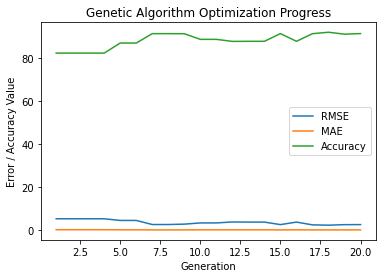

In [165]:
# Usage example for Bologna dataset
best_GAmodel_bologna = optimize_GA(bologna_meta_features, test_y_bologna)

In [166]:
# Use the best model 
best_GAmodel_bologna.fit(bologna_meta_features, test_y_bologna)
bologna_GA_pred = best_GAmodel_bologna.predict(bologna_meta_features)
# Evaluation Tools
# Call the eval_metrics function and store the results in variables
bologna_GA_adj_R, bologna_GA_rmse, bologna_GA_mae, bologna_GA_accuracy = eval_metrics(test_y_bologna, bologna_GA_pred, bologna_meta_features)
# Print the results
print("Adjusted R-squared:", bologna_GA_adj_R)
print("RMSE:", bologna_GA_rmse)
print("Mean Absolute Error:", bologna_GA_mae)
print("Accuracy:", bologna_GA_accuracy, "%")

Adjusted R-squared: 0.92
RMSE: 2.28
Mean Absolute Error: 0.08
Accuracy: 92.08 %


# Correlation of iImportant Factors

## Rank Correlation
1. Measures of Kendall's Tau
2. Measures of Spearman's Rank Correlation

In [168]:
from scipy.stats import kendalltau, spearmanr

# Store values with top 10 important features for each city as a list type
berg = bergamo_xgb_10top['Variable'].tolist()
rome = roma_xgb_10top['Variable'].tolist()
milan =milano_xgb_10top['Variable'].tolist()
sicily = sicilia_xgb_10top['Variable'].tolist()
trento = trentino_xgb_10top['Variable'].tolist()
apuglia = puglia_xgb_10top['Variable'].tolist()
florence  = firenze_xgb_10top['Variable'].tolist()
venice  = venezia_xgb_10top['Variable'].tolist()
naples  = napoli_xgb_10top['Variable'].tolist()
bolog  = bologna_xgb_10top['Variable'].tolist()

In [169]:
# Put together the lists of important factors of each city, again in a list.
cities_factors = [berg, rome, milan, sicily, trento, apuglia, florence, venice, naples, bolog]

# Initialise Kendall's Tau Matrix and Spearman's Rank Correlation Matrix 
num_cities = len(cities_factors)
kendall_tau_matrix = np.zeros((num_cities, num_cities))
spearman_corr_matrix = np.zeros((num_cities, num_cities))

# Calculate Kendall's Tau: each elements of cities_factors  Kendall's Tau 
for i in range(num_cities):
    for j in range(num_cities):
        tau, _ = kendalltau(cities_factors[i], cities_factors[j])
        kendall_tau_matrix[i, j] = tau
        
# Calculate Spearman's Rank Correlation Coefficient: each elements of cities_factors  Kendall's Tau 
for i in range(num_cities):
    for j in range(num_cities):
        corr, _ = spearmanr(cities_factors[i], cities_factors[j])
        spearman_corr_matrix[i, j] = corr

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [170]:
#   # Visualise Kendall's Tau 
# plt.figure(figsize=(7, 5))
# sns.heatmap(kendall_tau_matrix, annot=True, cmap="coolwarm", fmt=".2f",
#             xticklabels=["Bergamo", "Roma", "Milano", "Sicilia", "Trentino", "Puglia", "Firenze", "Venezia", "Napoli", "Bologna"],
#             yticklabels=["Bergamo", "Roma", "Milano", "Sicilia", "Trentino", "Puglia", "Firenze", "Venezia", "Napoli", "Bologna"])
# plt.title("Kendall's Tau Matrix")
# plt.show()

# # Visualise Spearman's Rank Correlation 
# plt.figure(figsize=(7, 5))
# sns.heatmap(spearman_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",
#             xticklabels=["Bergamo", "Roma", "Milano", "Sicilia", "Trentino", "Puglia", "Firenze", "Venezia", "Napoli", "Bologna"],
#             yticklabels=["Bergamo", "Roma", "Milano", "Sicilia", "Trentino", "Puglia", "Firenze", "Venezia", "Napoli", "Bologna"])
# plt.title("Spearman's Rank Correlation Matrix")
# plt.show()

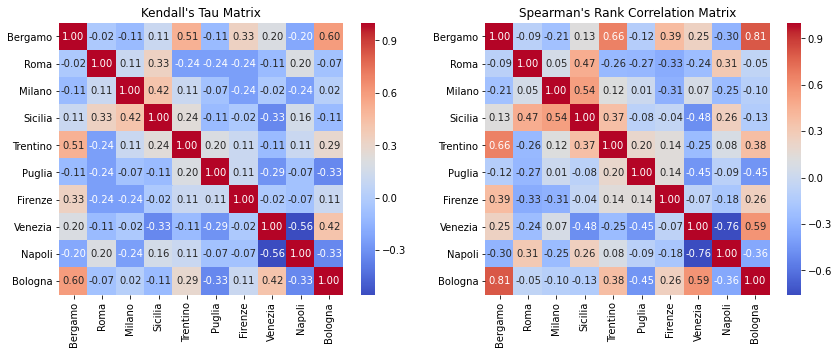

In [171]:
# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Visualise Kendall's Tau 
sns.heatmap(kendall_tau_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=["Bergamo", "Roma", "Milano", "Sicilia", "Trentino", "Puglia", "Firenze", "Venezia", "Napoli", "Bologna"],
            yticklabels=["Bergamo", "Roma", "Milano", "Sicilia", "Trentino", "Puglia", "Firenze", "Venezia", "Napoli", "Bologna"],
            ax=axes[0])
axes[0].set_title("Kendall's Tau Matrix")

# Visualise Spearman's Rank Correlation 
sns.heatmap(spearman_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=["Bergamo", "Roma", "Milano", "Sicilia", "Trentino", "Puglia", "Firenze", "Venezia", "Napoli", "Bologna"],
            yticklabels=["Bergamo", "Roma", "Milano", "Sicilia", "Trentino", "Puglia", "Firenze", "Venezia", "Napoli", "Bologna"],
            ax=axes[1])
axes[1].set_title("Spearman's Rank Correlation Matrix")

plt.show()

## Frequancy Visualisation of top factors in all cities

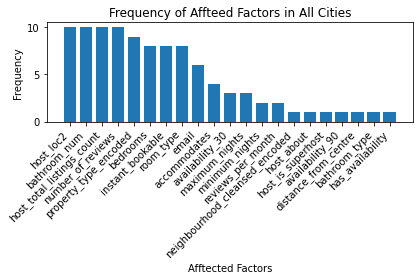

In [325]:
# Combine all lists into a single list
all_lists = rome + milan + berg + sicily + trento + apuglia + florence + venice + naples + bolog

# Get frequency of unique values for all lists combined and preserve the order
unique_freq = OrderedDict(Counter(all_lists))

# Sort the unique values by frequency in descending order
sorted_unique_freq = dict(sorted(unique_freq.items(), key=lambda item: item[1], reverse=True))

# Convert the dictionary into lists for plotting
unique_values = list(sorted_unique_freq.keys())
frequencies = list(sorted_unique_freq.values())

# Plot the histogram
plt.bar(unique_values, frequencies)
plt.xlabel('Afftected Factors')
plt.ylabel('Frequency')
plt.title('Frequency of Affteed Factors in All Cities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Store evaluation values in Dataframes for Comparison Visualisations

## evaluation metrics

In [173]:
locations = ['bergamo', 'roma', 'milano', 'sicilia', 'trentino', 'puglia', 'firenze', 'venezia', 'napoli', 'bologna']
models = ['rf', 'gb', 'lgb', 'xgb', 'stack', 'bayes', 'GA']
metrics = ['adj_R', 'rmse', 'mae', 'accuracy']

# Initialise dictionaries to contain data
data = {metric: [] for metric in metrics}

# Get the data based on the variable name pattern and adds it to the dictionary.
for location in locations:
    for model in models:
        for metric in metrics:
            var_name = f'{location}_{model}_{metric}'
            data[metric].append(globals()[var_name])
            
output_df = pd.DataFrame(data, index=[f'{loc}_{model}' for loc in locations for model in models])
output_df 

,adj_R,rmse,mae,accuracy
bergamo_rf,0.58,5.27,0.19,80.98
bergamo_gb,0.55,5.46,0.20,80.12
bergamo_lgb,0.57,5.37,0.19,80.57
bergamo_xgb,0.53,5.59,0.20,80.29
bergamo_stack,1.00,0.16,0.01,99.41
...,...,...,...,...
bologna_lgb,0.52,5.40,0.17,82.76
bologna_xgb,0.46,5.72,0.18,81.96
bologna_stack,1.00,0.34,0.01,98.84
bologna_bayes,0.92,2.27,0.08,91.73


In [174]:
output_df.to_csv('output_measurement.csv', index=True)

In [ ]:
# # Data Import
# output_eval = pd.read_csv('output_measurement.csv')
# output_eval

## Params from best models .to_csv

In [292]:
# Don't need to put all the variables into dataframe because each method has the same best model and parameters.
# I put all the variables just in case

data = {
    'Method' : ['rf', 'gb', 'lgb', 'xgb', 'stack', 'bayes', 'GA'],
    'bergamo': [bergamo_rf_model, bergamo_gb_model, bergamo_lgb_model, bergamo_xgb_model, bergamo_stack_model, bergamo_bayes_opt.best_params_, best_GAmodel_bergamo],
    'roma': [roma_rf_model, roma_gb_model, roma_lgb_model, roma_xgb_model, roma_stack_model, roma_bayes_opt.best_params_, best_GAmodel_roma],
    'milano': [milano_rf_model, milano_gb_model, milano_lgb_model, milano_xgb_model, milano_stack_model, milano_bayes_opt.best_params_, best_GAmodel_milano],
    'sicilia': [sicilia_rf_model, sicilia_gb_model, sicilia_lgb_model, sicilia_xgb_model, sicilia_stack_model, sicilia_bayes_opt.best_params_, best_GAmodel_sicilia],
    'trentino': [trentino_rf_model, trentino_gb_model, trentino_lgb_model, trentino_xgb_model, trentino_stack_model, trentino_bayes_opt.best_params_, best_GAmodel_trentino],
    'puglia': [puglia_rf_model, puglia_gb_model, puglia_lgb_model, puglia_xgb_model, puglia_stack_model, puglia_bayes_opt.best_params_, best_GAmodel_puglia],
    'firenze': [firenze_rf_model, firenze_gb_model, firenze_lgb_model, firenze_xgb_model, firenze_stack_model, firenze_bayes_opt.best_params_, best_GAmodel_firenze],
    'venezia': [venezia_rf_model, venezia_gb_model, venezia_lgb_model, venezia_xgb_model, venezia_stack_model, venezia_bayes_opt.best_params_, best_GAmodel_venezia],
    'napoli': [napoli_rf_model, napoli_gb_model, napoli_lgb_model, napoli_xgb_model, napoli_stack_model, napoli_bayes_opt.best_params_, best_GAmodel_napoli],
    'bologna': [bologna_rf_model, bologna_gb_model, bologna_lgb_model, bologna_xgb_model, bologna_stack_model, bologna_bayes_opt.best_params_, best_GAmodel_bologna]
    }

params = pd.DataFrame(data)
params.to_csv('best_params.csv', index=False)

In [6]:
# # Data Import
# best_params = pd.read_csv('best_params.csv')
# best_params

In [306]:
# Genetic Algorithm
print(best_params.loc[6, 'bergamo'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.07173330604877207,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.3661267728814921, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [310]:
# Bayesian Optimisation
print(best_params.loc[5, 'bergamo'])

OrderedDict([('gamma', 0.7703399241440627), ('learning_rate', 0.19204784774815406), ('max_depth', 2), ('n_estimators', 764)])


In [309]:
# XGBoost and Stacking are same based on shared XGBRegressor()
print(best_params.loc[4, 'bergamo'])
print(best_params.loc[3, 'bergamo'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=8, num_parallel_tree=1, random_state

In [308]:
# Base learners are same based on default settings
print(best_params.loc[2, 'bergamo'])
print(best_params.loc[1, 'bergamo'])
print(best_params.loc[0, 'bergamo'])

LGBMRegressor(n_estimators=190, random_state=123)
GradientBoostingRegressor(n_estimators=190, random_state=123)
RandomForestRegressor(n_estimators=190, random_state=123)
